# Miller age

In [1]:
ood_seed = 0

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_int"] = adata.obs["age"].astype(str).astype(float).astype(int).astype(str).astype("category")

adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [9]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask


def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Bud tip adjacent cells', '11.5'), 169)


Removed datapoint: 169

train         5768
validation    1468
ood            169
Name: split, dtype: int64

In [10]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="age_int",
    control_group="11",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['integration_donor'],
)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 98880.69it/s]

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 959168.07it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [13]:
model.train(max_epochs=400)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 228.04it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:03<20:45,  3.12s/it]

Epoch 1/400:   0%|          | 1/400 [00:03<20:45,  3.12s/it, v_num=1, recon=1.18e+3, r2_mean=0.0623, adv_loss=3.38, acc_pert=0.337, acc_integration_donor=0.146]

Epoch 2/400:   0%|          | 1/400 [00:03<20:45,  3.12s/it, v_num=1, recon=1.18e+3, r2_mean=0.0623, adv_loss=3.38, acc_pert=0.337, acc_integration_donor=0.146]

Epoch 2/400:   0%|          | 2/400 [00:05<19:11,  2.89s/it, v_num=1, recon=1.18e+3, r2_mean=0.0623, adv_loss=3.38, acc_pert=0.337, acc_integration_donor=0.146]

Epoch 2/400:   0%|          | 2/400 [00:05<19:11,  2.89s/it, v_num=1, recon=999, r2_mean=0.282, adv_loss=2.99, acc_pert=0.472, acc_integration_donor=0.313]     

Epoch 3/400:   0%|          | 2/400 [00:05<19:11,  2.89s/it, v_num=1, recon=999, r2_mean=0.282, adv_loss=2.99, acc_pert=0.472, acc_integration_donor=0.313]

Epoch 3/400:   1%|          | 3/400 [00:08<18:27,  2.79s/it, v_num=1, recon=999, r2_mean=0.282, adv_loss=2.99, acc_pert=0.472, acc_integration_donor=0.313]

Epoch 3/400:   1%|          | 3/400 [00:08<18:27,  2.79s/it, v_num=1, recon=932, r2_mean=0.37, adv_loss=2.68, acc_pert=0.526, acc_integration_donor=0.444] 

Epoch 4/400:   1%|          | 3/400 [00:08<18:27,  2.79s/it, v_num=1, recon=932, r2_mean=0.37, adv_loss=2.68, acc_pert=0.526, acc_integration_donor=0.444]

Epoch 4/400:   1%|          | 4/400 [00:11<18:14,  2.76s/it, v_num=1, recon=932, r2_mean=0.37, adv_loss=2.68, acc_pert=0.526, acc_integration_donor=0.444]

Epoch 4/400:   1%|          | 4/400 [00:11<18:14,  2.76s/it, v_num=1, recon=895, r2_mean=0.416, adv_loss=2.54, acc_pert=0.537, acc_integration_donor=0.506]

Epoch 5/400:   1%|          | 4/400 [00:11<18:14,  2.76s/it, v_num=1, recon=895, r2_mean=0.416, adv_loss=2.54, acc_pert=0.537, acc_integration_donor=0.506]

Epoch 5/400:   1%|▏         | 5/400 [00:14<19:07,  2.91s/it, v_num=1, recon=895, r2_mean=0.416, adv_loss=2.54, acc_pert=0.537, acc_integration_donor=0.506]

Epoch 5/400:   1%|▏         | 5/400 [00:14<19:07,  2.91s/it, v_num=1, recon=876, r2_mean=0.445, adv_loss=2.43, acc_pert=0.531, acc_integration_donor=0.508]

Epoch 6/400:   1%|▏         | 5/400 [00:14<19:07,  2.91s/it, v_num=1, recon=876, r2_mean=0.445, adv_loss=2.43, acc_pert=0.531, acc_integration_donor=0.508]

Epoch 6/400:   2%|▏         | 6/400 [00:17<19:16,  2.93s/it, v_num=1, recon=876, r2_mean=0.445, adv_loss=2.43, acc_pert=0.531, acc_integration_donor=0.508]

Epoch 6/400:   2%|▏         | 6/400 [00:17<19:16,  2.93s/it, v_num=1, recon=872, r2_mean=0.444, adv_loss=2.38, acc_pert=0.526, acc_integration_donor=0.517]

Epoch 7/400:   2%|▏         | 6/400 [00:17<19:16,  2.93s/it, v_num=1, recon=872, r2_mean=0.444, adv_loss=2.38, acc_pert=0.526, acc_integration_donor=0.517]

Epoch 7/400:   2%|▏         | 7/400 [00:20<19:05,  2.92s/it, v_num=1, recon=872, r2_mean=0.444, adv_loss=2.38, acc_pert=0.526, acc_integration_donor=0.517]

Epoch 7/400:   2%|▏         | 7/400 [00:20<19:05,  2.92s/it, v_num=1, recon=856, r2_mean=0.449, adv_loss=2.33, acc_pert=0.518, acc_integration_donor=0.529]

Epoch 8/400:   2%|▏         | 7/400 [00:20<19:05,  2.92s/it, v_num=1, recon=856, r2_mean=0.449, adv_loss=2.33, acc_pert=0.518, acc_integration_donor=0.529]

Epoch 8/400:   2%|▏         | 8/400 [00:23<20:18,  3.11s/it, v_num=1, recon=856, r2_mean=0.449, adv_loss=2.33, acc_pert=0.518, acc_integration_donor=0.529]

Epoch 8/400:   2%|▏         | 8/400 [00:23<20:18,  3.11s/it, v_num=1, recon=855, r2_mean=0.455, adv_loss=2.3, acc_pert=0.5, acc_integration_donor=0.535]   

Epoch 9/400:   2%|▏         | 8/400 [00:23<20:18,  3.11s/it, v_num=1, recon=855, r2_mean=0.455, adv_loss=2.3, acc_pert=0.5, acc_integration_donor=0.535]

Epoch 9/400:   2%|▏         | 9/400 [00:27<21:53,  3.36s/it, v_num=1, recon=855, r2_mean=0.455, adv_loss=2.3, acc_pert=0.5, acc_integration_donor=0.535]

Epoch 9/400:   2%|▏         | 9/400 [00:27<21:53,  3.36s/it, v_num=1, recon=849, r2_mean=0.46, adv_loss=2.29, acc_pert=0.522, acc_integration_donor=0.532]

Epoch 10/400:   2%|▏         | 9/400 [00:27<21:53,  3.36s/it, v_num=1, recon=849, r2_mean=0.46, adv_loss=2.29, acc_pert=0.522, acc_integration_donor=0.532]


disnt_basal = 0.5160033985985651

disnt_after = 0.9326656542710942

val_r2_mean = 0.48794947298509733

val_r2_var = 0.20365395228422822


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:33<26:39,  4.10s/it, v_num=1, recon=849, r2_mean=0.46, adv_loss=2.29, acc_pert=0.522, acc_integration_donor=0.532]

Epoch 10/400:   2%|▎         | 10/400 [00:33<26:39,  4.10s/it, v_num=1, recon=848, r2_mean=0.474, adv_loss=2.22, acc_pert=0.541, acc_integration_donor=0.53, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:33<26:39,  4.10s/it, v_num=1, recon=848, r2_mean=0.474, adv_loss=2.22, acc_pert=0.541, acc_integration_donor=0.53, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:37<26:04,  4.02s/it, v_num=1, recon=848, r2_mean=0.474, adv_loss=2.22, acc_pert=0.541, acc_integration_donor=0.53, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:37<26:04,  4.02s/it, v_num=1, recon=840, r2_mean=0.48, adv_loss=2.22, acc_pert=0.542, acc_integration_donor=0.519, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:37<26:04,  4.02s/it, v_num=1, recon=840, r2_mean=0.48, adv_loss=2.22, acc_pert=0.542, acc_integration_donor=0.519, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:40<24:12,  3.74s/it, v_num=1, recon=840, r2_mean=0.48, adv_loss=2.22, acc_pert=0.542, acc_integration_donor=0.519, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:40<24:12,  3.74s/it, v_num=1, recon=835, r2_mean=0.483, adv_loss=2.2, acc_pert=0.548, acc_integration_donor=0.526, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [00:40<24:12,  3.74s/it, v_num=1, recon=835, r2_mean=0.483, adv_loss=2.2, acc_pert=0.548, acc_integration_donor=0.526, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:43<22:32,  3.49s/it, v_num=1, recon=835, r2_mean=0.483, adv_loss=2.2, acc_pert=0.548, acc_integration_donor=0.526, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:43<22:32,  3.49s/it, v_num=1, recon=833, r2_mean=0.488, adv_loss=2.15, acc_pert=0.565, acc_integration_donor=0.523, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:43<22:32,  3.49s/it, v_num=1, recon=833, r2_mean=0.488, adv_loss=2.15, acc_pert=0.565, acc_integration_donor=0.523, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:46<21:25,  3.33s/it, v_num=1, recon=833, r2_mean=0.488, adv_loss=2.15, acc_pert=0.565, acc_integration_donor=0.523, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:46<21:25,  3.33s/it, v_num=1, recon=833, r2_mean=0.494, adv_loss=2.15, acc_pert=0.569, acc_integration_donor=0.515, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [00:46<21:25,  3.33s/it, v_num=1, recon=833, r2_mean=0.494, adv_loss=2.15, acc_pert=0.569, acc_integration_donor=0.515, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:48<20:07,  3.14s/it, v_num=1, recon=833, r2_mean=0.494, adv_loss=2.15, acc_pert=0.569, acc_integration_donor=0.515, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:48<20:07,  3.14s/it, v_num=1, recon=824, r2_mean=0.488, adv_loss=2.17, acc_pert=0.568, acc_integration_donor=0.511, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [00:48<20:07,  3.14s/it, v_num=1, recon=824, r2_mean=0.488, adv_loss=2.17, acc_pert=0.568, acc_integration_donor=0.511, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:51<19:37,  3.07s/it, v_num=1, recon=824, r2_mean=0.488, adv_loss=2.17, acc_pert=0.568, acc_integration_donor=0.511, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:51<19:37,  3.07s/it, v_num=1, recon=823, r2_mean=0.501, adv_loss=2.18, acc_pert=0.565, acc_integration_donor=0.519, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [00:51<19:37,  3.07s/it, v_num=1, recon=823, r2_mean=0.501, adv_loss=2.18, acc_pert=0.565, acc_integration_donor=0.519, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:54<19:19,  3.03s/it, v_num=1, recon=823, r2_mean=0.501, adv_loss=2.18, acc_pert=0.565, acc_integration_donor=0.519, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:54<19:19,  3.03s/it, v_num=1, recon=822, r2_mean=0.499, adv_loss=2.14, acc_pert=0.564, acc_integration_donor=0.516, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [00:54<19:19,  3.03s/it, v_num=1, recon=822, r2_mean=0.499, adv_loss=2.14, acc_pert=0.564, acc_integration_donor=0.516, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:59<23:04,  3.62s/it, v_num=1, recon=822, r2_mean=0.499, adv_loss=2.14, acc_pert=0.564, acc_integration_donor=0.516, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:59<23:04,  3.62s/it, v_num=1, recon=818, r2_mean=0.502, adv_loss=2.17, acc_pert=0.54, acc_integration_donor=0.527, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan] 

Epoch 19/400:   4%|▍         | 18/400 [00:59<23:04,  3.62s/it, v_num=1, recon=818, r2_mean=0.502, adv_loss=2.17, acc_pert=0.54, acc_integration_donor=0.527, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:02<22:02,  3.47s/it, v_num=1, recon=818, r2_mean=0.502, adv_loss=2.17, acc_pert=0.54, acc_integration_donor=0.527, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:02<22:02,  3.47s/it, v_num=1, recon=818, r2_mean=0.507, adv_loss=2.15, acc_pert=0.559, acc_integration_donor=0.526, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:02<22:02,  3.47s/it, v_num=1, recon=818, r2_mean=0.507, adv_loss=2.15, acc_pert=0.559, acc_integration_donor=0.526, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]


disnt_basal = 0.5076735224298062

disnt_after = 0.8773091604143214

val_r2_mean = 0.4923852055023114

val_r2_var = 0.3045903816819191

Epoch 20/400:   5%|▌         | 20/400 [01:17<42:27,  6.70s/it, v_num=1, recon=818, r2_mean=0.507, adv_loss=2.15, acc_pert=0.559, acc_integration_donor=0.526, val_recon=867, disnt_basal=0.516, disnt_after=0.933, val_r2_mean=0.488, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:17<42:27,  6.70s/it, v_num=1, recon=817, r2_mean=0.503, adv_loss=2.14, acc_pert=0.564, acc_integration_donor=0.532, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [01:17<42:27,  6.70s/it, v_num=1, recon=817, r2_mean=0.503, adv_loss=2.14, acc_pert=0.564, acc_integration_donor=0.532, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:20<35:00,  5.54s/it, v_num=1, recon=817, r2_mean=0.503, adv_loss=2.14, acc_pert=0.564, acc_integration_donor=0.532, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:20<35:00,  5.54s/it, v_num=1, recon=810, r2_mean=0.509, adv_loss=2.16, acc_pert=0.566, acc_integration_donor=0.513, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:20<35:00,  5.54s/it, v_num=1, recon=810, r2_mean=0.509, adv_loss=2.16, acc_pert=0.566, acc_integration_donor=0.513, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:22<29:36,  4.70s/it, v_num=1, recon=810, r2_mean=0.509, adv_loss=2.16, acc_pert=0.566, acc_integration_donor=0.513, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:22<29:36,  4.70s/it, v_num=1, recon=812, r2_mean=0.51, adv_loss=2.19, acc_pert=0.557, acc_integration_donor=0.515, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan] 

Epoch 23/400:   6%|▌         | 22/400 [01:22<29:36,  4.70s/it, v_num=1, recon=812, r2_mean=0.51, adv_loss=2.19, acc_pert=0.557, acc_integration_donor=0.515, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:25<25:52,  4.12s/it, v_num=1, recon=812, r2_mean=0.51, adv_loss=2.19, acc_pert=0.557, acc_integration_donor=0.515, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:25<25:52,  4.12s/it, v_num=1, recon=806, r2_mean=0.516, adv_loss=2.23, acc_pert=0.541, acc_integration_donor=0.503, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:25<25:52,  4.12s/it, v_num=1, recon=806, r2_mean=0.516, adv_loss=2.23, acc_pert=0.541, acc_integration_donor=0.503, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:28<23:12,  3.70s/it, v_num=1, recon=806, r2_mean=0.516, adv_loss=2.23, acc_pert=0.541, acc_integration_donor=0.503, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:28<23:12,  3.70s/it, v_num=1, recon=808, r2_mean=0.512, adv_loss=2.19, acc_pert=0.565, acc_integration_donor=0.511, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:28<23:12,  3.70s/it, v_num=1, recon=808, r2_mean=0.512, adv_loss=2.19, acc_pert=0.565, acc_integration_donor=0.511, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:31<21:23,  3.42s/it, v_num=1, recon=808, r2_mean=0.512, adv_loss=2.19, acc_pert=0.565, acc_integration_donor=0.511, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:31<21:23,  3.42s/it, v_num=1, recon=811, r2_mean=0.518, adv_loss=2.23, acc_pert=0.545, acc_integration_donor=0.515, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:31<21:23,  3.42s/it, v_num=1, recon=811, r2_mean=0.518, adv_loss=2.23, acc_pert=0.545, acc_integration_donor=0.515, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:33<20:06,  3.23s/it, v_num=1, recon=811, r2_mean=0.518, adv_loss=2.23, acc_pert=0.545, acc_integration_donor=0.515, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:33<20:06,  3.23s/it, v_num=1, recon=807, r2_mean=0.517, adv_loss=2.2, acc_pert=0.546, acc_integration_donor=0.509, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan] 

Epoch 27/400:   6%|▋         | 26/400 [01:33<20:06,  3.23s/it, v_num=1, recon=807, r2_mean=0.517, adv_loss=2.2, acc_pert=0.546, acc_integration_donor=0.509, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:36<19:38,  3.16s/it, v_num=1, recon=807, r2_mean=0.517, adv_loss=2.2, acc_pert=0.546, acc_integration_donor=0.509, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:36<19:38,  3.16s/it, v_num=1, recon=802, r2_mean=0.517, adv_loss=2.2, acc_pert=0.56, acc_integration_donor=0.507, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan] 

Epoch 28/400:   7%|▋         | 27/400 [01:36<19:38,  3.16s/it, v_num=1, recon=802, r2_mean=0.517, adv_loss=2.2, acc_pert=0.56, acc_integration_donor=0.507, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:39<18:56,  3.06s/it, v_num=1, recon=802, r2_mean=0.517, adv_loss=2.2, acc_pert=0.56, acc_integration_donor=0.507, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:39<18:56,  3.06s/it, v_num=1, recon=804, r2_mean=0.524, adv_loss=2.17, acc_pert=0.548, acc_integration_donor=0.519, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [01:39<18:56,  3.06s/it, v_num=1, recon=804, r2_mean=0.524, adv_loss=2.17, acc_pert=0.548, acc_integration_donor=0.519, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:42<18:21,  2.97s/it, v_num=1, recon=804, r2_mean=0.524, adv_loss=2.17, acc_pert=0.548, acc_integration_donor=0.519, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:42<18:21,  2.97s/it, v_num=1, recon=804, r2_mean=0.525, adv_loss=2.16, acc_pert=0.557, acc_integration_donor=0.517, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [01:42<18:21,  2.97s/it, v_num=1, recon=804, r2_mean=0.525, adv_loss=2.16, acc_pert=0.557, acc_integration_donor=0.517, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]


disnt_basal = 0.49923158522897443

disnt_after = 0.9046363295741292

val_r2_mean = 0.4981885651747386

val_r2_var = 0.33449700723091763


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [01:48<24:43,  4.01s/it, v_num=1, recon=804, r2_mean=0.525, adv_loss=2.16, acc_pert=0.557, acc_integration_donor=0.517, val_recon=846, disnt_basal=0.508, disnt_after=0.877, val_r2_mean=0.492, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [01:48<24:43,  4.01s/it, v_num=1, recon=808, r2_mean=0.521, adv_loss=2.19, acc_pert=0.547, acc_integration_donor=0.511, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [01:48<24:43,  4.01s/it, v_num=1, recon=808, r2_mean=0.521, adv_loss=2.19, acc_pert=0.547, acc_integration_donor=0.511, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:51<22:53,  3.72s/it, v_num=1, recon=808, r2_mean=0.521, adv_loss=2.19, acc_pert=0.547, acc_integration_donor=0.511, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:51<22:53,  3.72s/it, v_num=1, recon=803, r2_mean=0.523, adv_loss=2.17, acc_pert=0.556, acc_integration_donor=0.52, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan] 

Epoch 32/400:   8%|▊         | 31/400 [01:51<22:53,  3.72s/it, v_num=1, recon=803, r2_mean=0.523, adv_loss=2.17, acc_pert=0.556, acc_integration_donor=0.52, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:54<20:58,  3.42s/it, v_num=1, recon=803, r2_mean=0.523, adv_loss=2.17, acc_pert=0.556, acc_integration_donor=0.52, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:54<20:58,  3.42s/it, v_num=1, recon=803, r2_mean=0.525, adv_loss=2.11, acc_pert=0.571, acc_integration_donor=0.535, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [01:54<20:58,  3.42s/it, v_num=1, recon=803, r2_mean=0.525, adv_loss=2.11, acc_pert=0.571, acc_integration_donor=0.535, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:57<19:38,  3.21s/it, v_num=1, recon=803, r2_mean=0.525, adv_loss=2.11, acc_pert=0.571, acc_integration_donor=0.535, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:57<19:38,  3.21s/it, v_num=1, recon=801, r2_mean=0.522, adv_loss=2.14, acc_pert=0.546, acc_integration_donor=0.53, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan] 

Epoch 34/400:   8%|▊         | 33/400 [01:57<19:38,  3.21s/it, v_num=1, recon=801, r2_mean=0.522, adv_loss=2.14, acc_pert=0.546, acc_integration_donor=0.53, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:00<19:58,  3.27s/it, v_num=1, recon=801, r2_mean=0.522, adv_loss=2.14, acc_pert=0.546, acc_integration_donor=0.53, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:00<19:58,  3.27s/it, v_num=1, recon=795, r2_mean=0.523, adv_loss=2.12, acc_pert=0.571, acc_integration_donor=0.537, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [02:00<19:58,  3.27s/it, v_num=1, recon=795, r2_mean=0.523, adv_loss=2.12, acc_pert=0.571, acc_integration_donor=0.537, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:03<19:16,  3.17s/it, v_num=1, recon=795, r2_mean=0.523, adv_loss=2.12, acc_pert=0.571, acc_integration_donor=0.537, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:03<19:16,  3.17s/it, v_num=1, recon=804, r2_mean=0.525, adv_loss=2.09, acc_pert=0.581, acc_integration_donor=0.532, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [02:03<19:16,  3.17s/it, v_num=1, recon=804, r2_mean=0.525, adv_loss=2.09, acc_pert=0.581, acc_integration_donor=0.532, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:06<18:42,  3.08s/it, v_num=1, recon=804, r2_mean=0.525, adv_loss=2.09, acc_pert=0.581, acc_integration_donor=0.532, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:06<18:42,  3.08s/it, v_num=1, recon=803, r2_mean=0.53, adv_loss=2.13, acc_pert=0.572, acc_integration_donor=0.53, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]  

Epoch 37/400:   9%|▉         | 36/400 [02:06<18:42,  3.08s/it, v_num=1, recon=803, r2_mean=0.53, adv_loss=2.13, acc_pert=0.572, acc_integration_donor=0.53, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:09<18:25,  3.04s/it, v_num=1, recon=803, r2_mean=0.53, adv_loss=2.13, acc_pert=0.572, acc_integration_donor=0.53, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:09<18:25,  3.04s/it, v_num=1, recon=794, r2_mean=0.523, adv_loss=2.11, acc_pert=0.577, acc_integration_donor=0.533, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [02:09<18:25,  3.04s/it, v_num=1, recon=794, r2_mean=0.523, adv_loss=2.11, acc_pert=0.577, acc_integration_donor=0.533, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:12<18:27,  3.06s/it, v_num=1, recon=794, r2_mean=0.523, adv_loss=2.11, acc_pert=0.577, acc_integration_donor=0.533, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:12<18:27,  3.06s/it, v_num=1, recon=795, r2_mean=0.532, adv_loss=2.11, acc_pert=0.569, acc_integration_donor=0.527, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [02:12<18:27,  3.06s/it, v_num=1, recon=795, r2_mean=0.532, adv_loss=2.11, acc_pert=0.569, acc_integration_donor=0.527, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:15<18:14,  3.03s/it, v_num=1, recon=795, r2_mean=0.532, adv_loss=2.11, acc_pert=0.569, acc_integration_donor=0.527, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:15<18:14,  3.03s/it, v_num=1, recon=796, r2_mean=0.538, adv_loss=2.14, acc_pert=0.545, acc_integration_donor=0.528, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [02:15<18:14,  3.03s/it, v_num=1, recon=796, r2_mean=0.538, adv_loss=2.14, acc_pert=0.545, acc_integration_donor=0.528, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]


disnt_basal = 0.5059710982893345

disnt_after = 0.9098123038078048

val_r2_mean = 0.5000668851924794

val_r2_var = 0.3435457350597495


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [02:28<35:22,  5.90s/it, v_num=1, recon=796, r2_mean=0.538, adv_loss=2.14, acc_pert=0.545, acc_integration_donor=0.528, val_recon=839, disnt_basal=0.499, disnt_after=0.905, val_r2_mean=0.498, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [02:28<35:22,  5.90s/it, v_num=1, recon=797, r2_mean=0.529, adv_loss=2.11, acc_pert=0.552, acc_integration_donor=0.538, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]   

Epoch 41/400:  10%|█         | 40/400 [02:28<35:22,  5.90s/it, v_num=1, recon=797, r2_mean=0.529, adv_loss=2.11, acc_pert=0.552, acc_integration_donor=0.538, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:30<29:41,  4.96s/it, v_num=1, recon=797, r2_mean=0.529, adv_loss=2.11, acc_pert=0.552, acc_integration_donor=0.538, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:30<29:41,  4.96s/it, v_num=1, recon=794, r2_mean=0.532, adv_loss=2.12, acc_pert=0.559, acc_integration_donor=0.532, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [02:30<29:41,  4.96s/it, v_num=1, recon=794, r2_mean=0.532, adv_loss=2.12, acc_pert=0.559, acc_integration_donor=0.532, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:33<25:34,  4.29s/it, v_num=1, recon=794, r2_mean=0.532, adv_loss=2.12, acc_pert=0.559, acc_integration_donor=0.532, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:33<25:34,  4.29s/it, v_num=1, recon=794, r2_mean=0.533, adv_loss=2.1, acc_pert=0.564, acc_integration_donor=0.54, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]  

Epoch 43/400:  10%|█         | 42/400 [02:33<25:34,  4.29s/it, v_num=1, recon=794, r2_mean=0.533, adv_loss=2.1, acc_pert=0.564, acc_integration_donor=0.54, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:36<22:35,  3.80s/it, v_num=1, recon=794, r2_mean=0.533, adv_loss=2.1, acc_pert=0.564, acc_integration_donor=0.54, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:36<22:35,  3.80s/it, v_num=1, recon=791, r2_mean=0.538, adv_loss=2.14, acc_pert=0.555, acc_integration_donor=0.538, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [02:36<22:35,  3.80s/it, v_num=1, recon=791, r2_mean=0.538, adv_loss=2.14, acc_pert=0.555, acc_integration_donor=0.538, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:39<21:04,  3.55s/it, v_num=1, recon=791, r2_mean=0.538, adv_loss=2.14, acc_pert=0.555, acc_integration_donor=0.538, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:39<21:04,  3.55s/it, v_num=1, recon=794, r2_mean=0.539, adv_loss=2.11, acc_pert=0.563, acc_integration_donor=0.539, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [02:39<21:04,  3.55s/it, v_num=1, recon=794, r2_mean=0.539, adv_loss=2.11, acc_pert=0.563, acc_integration_donor=0.539, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:42<20:04,  3.39s/it, v_num=1, recon=794, r2_mean=0.539, adv_loss=2.11, acc_pert=0.563, acc_integration_donor=0.539, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:42<20:04,  3.39s/it, v_num=1, recon=793, r2_mean=0.532, adv_loss=2.12, acc_pert=0.558, acc_integration_donor=0.532, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [02:42<20:04,  3.39s/it, v_num=1, recon=793, r2_mean=0.532, adv_loss=2.12, acc_pert=0.558, acc_integration_donor=0.532, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:44<18:46,  3.18s/it, v_num=1, recon=793, r2_mean=0.532, adv_loss=2.12, acc_pert=0.558, acc_integration_donor=0.532, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:44<18:46,  3.18s/it, v_num=1, recon=792, r2_mean=0.541, adv_loss=2.13, acc_pert=0.551, acc_integration_donor=0.536, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [02:44<18:46,  3.18s/it, v_num=1, recon=792, r2_mean=0.541, adv_loss=2.13, acc_pert=0.551, acc_integration_donor=0.536, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:47<17:51,  3.04s/it, v_num=1, recon=792, r2_mean=0.541, adv_loss=2.13, acc_pert=0.551, acc_integration_donor=0.536, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:47<17:51,  3.04s/it, v_num=1, recon=787, r2_mean=0.538, adv_loss=2.17, acc_pert=0.552, acc_integration_donor=0.525, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [02:47<17:51,  3.04s/it, v_num=1, recon=787, r2_mean=0.538, adv_loss=2.17, acc_pert=0.552, acc_integration_donor=0.525, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:50<17:18,  2.95s/it, v_num=1, recon=787, r2_mean=0.538, adv_loss=2.17, acc_pert=0.552, acc_integration_donor=0.525, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:50<17:18,  2.95s/it, v_num=1, recon=785, r2_mean=0.541, adv_loss=2.16, acc_pert=0.538, acc_integration_donor=0.532, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [02:50<17:18,  2.95s/it, v_num=1, recon=785, r2_mean=0.541, adv_loss=2.16, acc_pert=0.538, acc_integration_donor=0.532, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:53<16:40,  2.85s/it, v_num=1, recon=785, r2_mean=0.541, adv_loss=2.16, acc_pert=0.538, acc_integration_donor=0.532, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:53<16:40,  2.85s/it, v_num=1, recon=791, r2_mean=0.542, adv_loss=2.15, acc_pert=0.553, acc_integration_donor=0.526, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [02:53<16:40,  2.85s/it, v_num=1, recon=791, r2_mean=0.542, adv_loss=2.15, acc_pert=0.553, acc_integration_donor=0.526, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]


disnt_basal = 0.49857536401807523

disnt_after = 0.8841810173810317

val_r2_mean = 0.5011584907770157

val_r2_var = 0.36563869441548985

Epoch 50/400:  12%|█▎        | 50/400 [02:57<20:06,  3.45s/it, v_num=1, recon=791, r2_mean=0.542, adv_loss=2.15, acc_pert=0.553, acc_integration_donor=0.526, val_recon=833, disnt_basal=0.506, disnt_after=0.91, val_r2_mean=0.5, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [02:57<20:06,  3.45s/it, v_num=1, recon=790, r2_mean=0.541, adv_loss=2.17, acc_pert=0.54, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [02:57<20:06,  3.45s/it, v_num=1, recon=790, r2_mean=0.541, adv_loss=2.17, acc_pert=0.54, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [03:00<18:32,  3.19s/it, v_num=1, recon=790, r2_mean=0.541, adv_loss=2.17, acc_pert=0.54, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [03:00<18:32,  3.19s/it, v_num=1, recon=788, r2_mean=0.541, adv_loss=2.16, acc_pert=0.551, acc_integration_donor=0.538, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [03:00<18:32,  3.19s/it, v_num=1, recon=788, r2_mean=0.541, adv_loss=2.16, acc_pert=0.551, acc_integration_donor=0.538, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [03:03<17:27,  3.01s/it, v_num=1, recon=788, r2_mean=0.541, adv_loss=2.16, acc_pert=0.551, acc_integration_donor=0.538, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [03:03<17:27,  3.01s/it, v_num=1, recon=787, r2_mean=0.547, adv_loss=2.17, acc_pert=0.532, acc_integration_donor=0.538, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [03:03<17:27,  3.01s/it, v_num=1, recon=787, r2_mean=0.547, adv_loss=2.17, acc_pert=0.532, acc_integration_donor=0.538, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [03:05<16:39,  2.88s/it, v_num=1, recon=787, r2_mean=0.547, adv_loss=2.17, acc_pert=0.532, acc_integration_donor=0.538, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [03:05<16:39,  2.88s/it, v_num=1, recon=786, r2_mean=0.54, adv_loss=2.17, acc_pert=0.535, acc_integration_donor=0.526, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan] 

Epoch 54/400:  13%|█▎        | 53/400 [03:05<16:39,  2.88s/it, v_num=1, recon=786, r2_mean=0.54, adv_loss=2.17, acc_pert=0.535, acc_integration_donor=0.526, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [03:08<16:09,  2.80s/it, v_num=1, recon=786, r2_mean=0.54, adv_loss=2.17, acc_pert=0.535, acc_integration_donor=0.526, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [03:08<16:09,  2.80s/it, v_num=1, recon=782, r2_mean=0.542, adv_loss=2.17, acc_pert=0.554, acc_integration_donor=0.533, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [03:08<16:09,  2.80s/it, v_num=1, recon=782, r2_mean=0.542, adv_loss=2.17, acc_pert=0.554, acc_integration_donor=0.533, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:11<16:13,  2.82s/it, v_num=1, recon=782, r2_mean=0.542, adv_loss=2.17, acc_pert=0.554, acc_integration_donor=0.533, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:11<16:13,  2.82s/it, v_num=1, recon=778, r2_mean=0.546, adv_loss=2.15, acc_pert=0.546, acc_integration_donor=0.53, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan] 

Epoch 56/400:  14%|█▍        | 55/400 [03:11<16:13,  2.82s/it, v_num=1, recon=778, r2_mean=0.546, adv_loss=2.15, acc_pert=0.546, acc_integration_donor=0.53, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:13<16:04,  2.80s/it, v_num=1, recon=778, r2_mean=0.546, adv_loss=2.15, acc_pert=0.546, acc_integration_donor=0.53, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:13<16:04,  2.80s/it, v_num=1, recon=782, r2_mean=0.55, adv_loss=2.13, acc_pert=0.55, acc_integration_donor=0.544, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan] 

Epoch 57/400:  14%|█▍        | 56/400 [03:13<16:04,  2.80s/it, v_num=1, recon=782, r2_mean=0.55, adv_loss=2.13, acc_pert=0.55, acc_integration_donor=0.544, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:16<16:07,  2.82s/it, v_num=1, recon=782, r2_mean=0.55, adv_loss=2.13, acc_pert=0.55, acc_integration_donor=0.544, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:16<16:07,  2.82s/it, v_num=1, recon=785, r2_mean=0.541, adv_loss=2.17, acc_pert=0.541, acc_integration_donor=0.533, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [03:16<16:07,  2.82s/it, v_num=1, recon=785, r2_mean=0.541, adv_loss=2.17, acc_pert=0.541, acc_integration_donor=0.533, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:19<16:11,  2.84s/it, v_num=1, recon=785, r2_mean=0.541, adv_loss=2.17, acc_pert=0.541, acc_integration_donor=0.533, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:19<16:11,  2.84s/it, v_num=1, recon=781, r2_mean=0.543, adv_loss=2.19, acc_pert=0.542, acc_integration_donor=0.519, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [03:19<16:11,  2.84s/it, v_num=1, recon=781, r2_mean=0.543, adv_loss=2.19, acc_pert=0.542, acc_integration_donor=0.519, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:22<16:37,  2.92s/it, v_num=1, recon=781, r2_mean=0.543, adv_loss=2.19, acc_pert=0.542, acc_integration_donor=0.519, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:22<16:37,  2.92s/it, v_num=1, recon=786, r2_mean=0.542, adv_loss=2.19, acc_pert=0.533, acc_integration_donor=0.526, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [03:22<16:37,  2.92s/it, v_num=1, recon=786, r2_mean=0.542, adv_loss=2.19, acc_pert=0.533, acc_integration_donor=0.526, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]


disnt_basal = 0.49395588391902656

disnt_after = 0.8852145481282215

val_r2_mean = 0.5029685230304798

val_r2_var = 0.36751042022591546

Epoch 60/400:  15%|█▌        | 60/400 [03:31<25:59,  4.59s/it, v_num=1, recon=786, r2_mean=0.542, adv_loss=2.19, acc_pert=0.533, acc_integration_donor=0.526, val_recon=835, disnt_basal=0.499, disnt_after=0.884, val_r2_mean=0.501, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [03:31<25:59,  4.59s/it, v_num=1, recon=779, r2_mean=0.539, adv_loss=2.17, acc_pert=0.541, acc_integration_donor=0.525, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [03:31<25:59,  4.59s/it, v_num=1, recon=779, r2_mean=0.539, adv_loss=2.17, acc_pert=0.541, acc_integration_donor=0.525, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:34<23:16,  4.12s/it, v_num=1, recon=779, r2_mean=0.539, adv_loss=2.17, acc_pert=0.541, acc_integration_donor=0.525, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:34<23:16,  4.12s/it, v_num=1, recon=782, r2_mean=0.547, adv_loss=2.15, acc_pert=0.537, acc_integration_donor=0.537, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [03:34<23:16,  4.12s/it, v_num=1, recon=782, r2_mean=0.547, adv_loss=2.15, acc_pert=0.537, acc_integration_donor=0.537, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:36<20:46,  3.69s/it, v_num=1, recon=782, r2_mean=0.547, adv_loss=2.15, acc_pert=0.537, acc_integration_donor=0.537, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:36<20:46,  3.69s/it, v_num=1, recon=774, r2_mean=0.547, adv_loss=2.2, acc_pert=0.54, acc_integration_donor=0.523, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]  

Epoch 63/400:  16%|█▌        | 62/400 [03:36<20:46,  3.69s/it, v_num=1, recon=774, r2_mean=0.547, adv_loss=2.2, acc_pert=0.54, acc_integration_donor=0.523, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:39<19:14,  3.42s/it, v_num=1, recon=774, r2_mean=0.547, adv_loss=2.2, acc_pert=0.54, acc_integration_donor=0.523, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:39<19:14,  3.42s/it, v_num=1, recon=780, r2_mean=0.546, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.529, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [03:39<19:14,  3.42s/it, v_num=1, recon=780, r2_mean=0.546, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.529, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:42<17:45,  3.17s/it, v_num=1, recon=780, r2_mean=0.546, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.529, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:42<17:45,  3.17s/it, v_num=1, recon=772, r2_mean=0.55, adv_loss=2.16, acc_pert=0.538, acc_integration_donor=0.536, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan] 

Epoch 65/400:  16%|█▌        | 64/400 [03:42<17:45,  3.17s/it, v_num=1, recon=772, r2_mean=0.55, adv_loss=2.16, acc_pert=0.538, acc_integration_donor=0.536, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:45<16:59,  3.04s/it, v_num=1, recon=772, r2_mean=0.55, adv_loss=2.16, acc_pert=0.538, acc_integration_donor=0.536, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:45<16:59,  3.04s/it, v_num=1, recon=776, r2_mean=0.548, adv_loss=2.2, acc_pert=0.535, acc_integration_donor=0.525, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [03:45<16:59,  3.04s/it, v_num=1, recon=776, r2_mean=0.548, adv_loss=2.2, acc_pert=0.535, acc_integration_donor=0.525, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:48<17:24,  3.13s/it, v_num=1, recon=776, r2_mean=0.548, adv_loss=2.2, acc_pert=0.535, acc_integration_donor=0.525, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:48<17:24,  3.13s/it, v_num=1, recon=774, r2_mean=0.554, adv_loss=2.17, acc_pert=0.535, acc_integration_donor=0.519, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [03:48<17:24,  3.13s/it, v_num=1, recon=774, r2_mean=0.554, adv_loss=2.17, acc_pert=0.535, acc_integration_donor=0.519, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:50<16:25,  2.96s/it, v_num=1, recon=774, r2_mean=0.554, adv_loss=2.17, acc_pert=0.535, acc_integration_donor=0.519, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:50<16:25,  2.96s/it, v_num=1, recon=770, r2_mean=0.549, adv_loss=2.19, acc_pert=0.542, acc_integration_donor=0.527, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [03:50<16:25,  2.96s/it, v_num=1, recon=770, r2_mean=0.549, adv_loss=2.19, acc_pert=0.542, acc_integration_donor=0.527, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:53<15:45,  2.85s/it, v_num=1, recon=770, r2_mean=0.549, adv_loss=2.19, acc_pert=0.542, acc_integration_donor=0.527, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:53<15:45,  2.85s/it, v_num=1, recon=771, r2_mean=0.55, adv_loss=2.19, acc_pert=0.537, acc_integration_donor=0.531, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan] 

Epoch 69/400:  17%|█▋        | 68/400 [03:53<15:45,  2.85s/it, v_num=1, recon=771, r2_mean=0.55, adv_loss=2.19, acc_pert=0.537, acc_integration_donor=0.531, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [03:56<15:13,  2.76s/it, v_num=1, recon=771, r2_mean=0.55, adv_loss=2.19, acc_pert=0.537, acc_integration_donor=0.531, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [03:56<15:13,  2.76s/it, v_num=1, recon=775, r2_mean=0.554, adv_loss=2.19, acc_pert=0.527, acc_integration_donor=0.532, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [03:56<15:13,  2.76s/it, v_num=1, recon=775, r2_mean=0.554, adv_loss=2.19, acc_pert=0.527, acc_integration_donor=0.532, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]


disnt_basal = 0.4894622903706988

disnt_after = 0.8995569461078667

val_r2_mean = 0.5070560162088701

val_r2_var = 0.36767816082352683


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [04:15<42:11,  7.67s/it, v_num=1, recon=775, r2_mean=0.554, adv_loss=2.19, acc_pert=0.527, acc_integration_donor=0.532, val_recon=832, disnt_basal=0.494, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [04:15<42:11,  7.67s/it, v_num=1, recon=777, r2_mean=0.553, adv_loss=2.19, acc_pert=0.522, acc_integration_donor=0.533, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]  

Epoch 71/400:  18%|█▊        | 70/400 [04:15<42:11,  7.67s/it, v_num=1, recon=777, r2_mean=0.553, adv_loss=2.19, acc_pert=0.522, acc_integration_donor=0.533, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:17<33:50,  6.17s/it, v_num=1, recon=777, r2_mean=0.553, adv_loss=2.19, acc_pert=0.522, acc_integration_donor=0.533, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:17<33:50,  6.17s/it, v_num=1, recon=770, r2_mean=0.553, adv_loss=2.22, acc_pert=0.53, acc_integration_donor=0.518, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan] 

Epoch 72/400:  18%|█▊        | 71/400 [04:17<33:50,  6.17s/it, v_num=1, recon=770, r2_mean=0.553, adv_loss=2.22, acc_pert=0.53, acc_integration_donor=0.518, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:20<28:00,  5.12s/it, v_num=1, recon=770, r2_mean=0.553, adv_loss=2.22, acc_pert=0.53, acc_integration_donor=0.518, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:20<28:00,  5.12s/it, v_num=1, recon=776, r2_mean=0.556, adv_loss=2.17, acc_pert=0.529, acc_integration_donor=0.539, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [04:20<28:00,  5.12s/it, v_num=1, recon=776, r2_mean=0.556, adv_loss=2.17, acc_pert=0.529, acc_integration_donor=0.539, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:23<24:10,  4.44s/it, v_num=1, recon=776, r2_mean=0.556, adv_loss=2.17, acc_pert=0.529, acc_integration_donor=0.539, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:23<24:10,  4.44s/it, v_num=1, recon=776, r2_mean=0.552, adv_loss=2.21, acc_pert=0.52, acc_integration_donor=0.53, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]  

Epoch 74/400:  18%|█▊        | 73/400 [04:23<24:10,  4.44s/it, v_num=1, recon=776, r2_mean=0.552, adv_loss=2.21, acc_pert=0.52, acc_integration_donor=0.53, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:26<22:02,  4.06s/it, v_num=1, recon=776, r2_mean=0.552, adv_loss=2.21, acc_pert=0.52, acc_integration_donor=0.53, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:26<22:02,  4.06s/it, v_num=1, recon=768, r2_mean=0.547, adv_loss=2.21, acc_pert=0.515, acc_integration_donor=0.531, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [04:26<22:02,  4.06s/it, v_num=1, recon=768, r2_mean=0.547, adv_loss=2.21, acc_pert=0.515, acc_integration_donor=0.531, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:29<20:23,  3.77s/it, v_num=1, recon=768, r2_mean=0.547, adv_loss=2.21, acc_pert=0.515, acc_integration_donor=0.531, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:29<20:23,  3.77s/it, v_num=1, recon=768, r2_mean=0.548, adv_loss=2.18, acc_pert=0.529, acc_integration_donor=0.54, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan] 

Epoch 76/400:  19%|█▉        | 75/400 [04:29<20:23,  3.77s/it, v_num=1, recon=768, r2_mean=0.548, adv_loss=2.18, acc_pert=0.529, acc_integration_donor=0.54, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:33<21:03,  3.90s/it, v_num=1, recon=768, r2_mean=0.548, adv_loss=2.18, acc_pert=0.529, acc_integration_donor=0.54, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:33<21:03,  3.90s/it, v_num=1, recon=768, r2_mean=0.556, adv_loss=2.21, acc_pert=0.523, acc_integration_donor=0.533, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [04:33<21:03,  3.90s/it, v_num=1, recon=768, r2_mean=0.556, adv_loss=2.21, acc_pert=0.523, acc_integration_donor=0.533, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:36<19:16,  3.58s/it, v_num=1, recon=768, r2_mean=0.556, adv_loss=2.21, acc_pert=0.523, acc_integration_donor=0.533, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:36<19:16,  3.58s/it, v_num=1, recon=766, r2_mean=0.551, adv_loss=2.21, acc_pert=0.54, acc_integration_donor=0.525, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan] 

Epoch 78/400:  19%|█▉        | 77/400 [04:36<19:16,  3.58s/it, v_num=1, recon=766, r2_mean=0.551, adv_loss=2.21, acc_pert=0.54, acc_integration_donor=0.525, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:39<18:01,  3.36s/it, v_num=1, recon=766, r2_mean=0.551, adv_loss=2.21, acc_pert=0.54, acc_integration_donor=0.525, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:39<18:01,  3.36s/it, v_num=1, recon=765, r2_mean=0.549, adv_loss=2.22, acc_pert=0.53, acc_integration_donor=0.526, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [04:39<18:01,  3.36s/it, v_num=1, recon=765, r2_mean=0.549, adv_loss=2.22, acc_pert=0.53, acc_integration_donor=0.526, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:43<18:30,  3.46s/it, v_num=1, recon=765, r2_mean=0.549, adv_loss=2.22, acc_pert=0.53, acc_integration_donor=0.526, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:43<18:30,  3.46s/it, v_num=1, recon=768, r2_mean=0.554, adv_loss=2.21, acc_pert=0.526, acc_integration_donor=0.529, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [04:43<18:30,  3.46s/it, v_num=1, recon=768, r2_mean=0.554, adv_loss=2.21, acc_pert=0.526, acc_integration_donor=0.529, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]


disnt_basal = 0.4741359431504489

disnt_after = 0.8747386692245837

val_r2_mean = 0.4895612404992183

val_r2_var = 0.3760299098988374

Epoch 80/400:  20%|██        | 80/400 [04:50<24:22,  4.57s/it, v_num=1, recon=768, r2_mean=0.554, adv_loss=2.21, acc_pert=0.526, acc_integration_donor=0.529, val_recon=834, disnt_basal=0.489, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [04:50<24:22,  4.57s/it, v_num=1, recon=777, r2_mean=0.553, adv_loss=2.24, acc_pert=0.536, acc_integration_donor=0.524, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [04:50<24:22,  4.57s/it, v_num=1, recon=777, r2_mean=0.553, adv_loss=2.24, acc_pert=0.536, acc_integration_donor=0.524, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:53<22:12,  4.18s/it, v_num=1, recon=777, r2_mean=0.553, adv_loss=2.24, acc_pert=0.536, acc_integration_donor=0.524, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:53<22:12,  4.18s/it, v_num=1, recon=773, r2_mean=0.55, adv_loss=2.22, acc_pert=0.524, acc_integration_donor=0.528, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan] 

Epoch 82/400:  20%|██        | 81/400 [04:53<22:12,  4.18s/it, v_num=1, recon=773, r2_mean=0.55, adv_loss=2.22, acc_pert=0.524, acc_integration_donor=0.528, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:56<20:16,  3.82s/it, v_num=1, recon=773, r2_mean=0.55, adv_loss=2.22, acc_pert=0.524, acc_integration_donor=0.528, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:56<20:16,  3.82s/it, v_num=1, recon=773, r2_mean=0.554, adv_loss=2.18, acc_pert=0.536, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [04:56<20:16,  3.82s/it, v_num=1, recon=773, r2_mean=0.554, adv_loss=2.18, acc_pert=0.536, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:59<19:15,  3.65s/it, v_num=1, recon=773, r2_mean=0.554, adv_loss=2.18, acc_pert=0.536, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:59<19:15,  3.65s/it, v_num=1, recon=774, r2_mean=0.549, adv_loss=2.18, acc_pert=0.543, acc_integration_donor=0.533, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [04:59<19:15,  3.65s/it, v_num=1, recon=774, r2_mean=0.549, adv_loss=2.18, acc_pert=0.543, acc_integration_donor=0.533, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [05:02<18:10,  3.45s/it, v_num=1, recon=774, r2_mean=0.549, adv_loss=2.18, acc_pert=0.543, acc_integration_donor=0.533, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [05:02<18:10,  3.45s/it, v_num=1, recon=767, r2_mean=0.551, adv_loss=2.17, acc_pert=0.544, acc_integration_donor=0.534, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [05:02<18:10,  3.45s/it, v_num=1, recon=767, r2_mean=0.551, adv_loss=2.17, acc_pert=0.544, acc_integration_donor=0.534, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [05:05<17:06,  3.26s/it, v_num=1, recon=767, r2_mean=0.551, adv_loss=2.17, acc_pert=0.544, acc_integration_donor=0.534, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [05:05<17:06,  3.26s/it, v_num=1, recon=768, r2_mean=0.558, adv_loss=2.14, acc_pert=0.54, acc_integration_donor=0.541, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan] 

Epoch 86/400:  21%|██▏       | 85/400 [05:05<17:06,  3.26s/it, v_num=1, recon=768, r2_mean=0.558, adv_loss=2.14, acc_pert=0.54, acc_integration_donor=0.541, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [05:08<16:22,  3.13s/it, v_num=1, recon=768, r2_mean=0.558, adv_loss=2.14, acc_pert=0.54, acc_integration_donor=0.541, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [05:08<16:22,  3.13s/it, v_num=1, recon=764, r2_mean=0.554, adv_loss=2.19, acc_pert=0.536, acc_integration_donor=0.527, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [05:08<16:22,  3.13s/it, v_num=1, recon=764, r2_mean=0.554, adv_loss=2.19, acc_pert=0.536, acc_integration_donor=0.527, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [05:11<15:56,  3.06s/it, v_num=1, recon=764, r2_mean=0.554, adv_loss=2.19, acc_pert=0.536, acc_integration_donor=0.527, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [05:11<15:56,  3.06s/it, v_num=1, recon=769, r2_mean=0.559, adv_loss=2.17, acc_pert=0.533, acc_integration_donor=0.531, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [05:11<15:56,  3.06s/it, v_num=1, recon=769, r2_mean=0.559, adv_loss=2.17, acc_pert=0.533, acc_integration_donor=0.531, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [05:14<15:50,  3.05s/it, v_num=1, recon=769, r2_mean=0.559, adv_loss=2.17, acc_pert=0.533, acc_integration_donor=0.531, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [05:14<15:50,  3.05s/it, v_num=1, recon=770, r2_mean=0.556, adv_loss=2.19, acc_pert=0.538, acc_integration_donor=0.543, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [05:14<15:50,  3.05s/it, v_num=1, recon=770, r2_mean=0.556, adv_loss=2.19, acc_pert=0.538, acc_integration_donor=0.543, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [05:17<15:56,  3.08s/it, v_num=1, recon=770, r2_mean=0.556, adv_loss=2.19, acc_pert=0.538, acc_integration_donor=0.543, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [05:17<15:56,  3.08s/it, v_num=1, recon=761, r2_mean=0.553, adv_loss=2.16, acc_pert=0.522, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [05:17<15:56,  3.08s/it, v_num=1, recon=761, r2_mean=0.553, adv_loss=2.16, acc_pert=0.522, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]


disnt_basal = 0.4870062132526884

disnt_after = 0.906377247022632

val_r2_mean = 0.5115466244696152

val_r2_var = 0.3788992882307087


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [05:32<35:01,  6.78s/it, v_num=1, recon=761, r2_mean=0.553, adv_loss=2.16, acc_pert=0.522, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.474, disnt_after=0.875, val_r2_mean=0.49, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [05:32<35:01,  6.78s/it, v_num=1, recon=762, r2_mean=0.554, adv_loss=2.19, acc_pert=0.543, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [05:32<35:01,  6.78s/it, v_num=1, recon=762, r2_mean=0.554, adv_loss=2.19, acc_pert=0.543, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:35<28:55,  5.62s/it, v_num=1, recon=762, r2_mean=0.554, adv_loss=2.19, acc_pert=0.543, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:35<28:55,  5.62s/it, v_num=1, recon=763, r2_mean=0.556, adv_loss=2.17, acc_pert=0.531, acc_integration_donor=0.527, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [05:35<28:55,  5.62s/it, v_num=1, recon=763, r2_mean=0.556, adv_loss=2.17, acc_pert=0.531, acc_integration_donor=0.527, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:38<24:21,  4.74s/it, v_num=1, recon=763, r2_mean=0.556, adv_loss=2.17, acc_pert=0.531, acc_integration_donor=0.527, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:38<24:21,  4.74s/it, v_num=1, recon=764, r2_mean=0.565, adv_loss=2.18, acc_pert=0.532, acc_integration_donor=0.527, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [05:38<24:21,  4.74s/it, v_num=1, recon=764, r2_mean=0.565, adv_loss=2.18, acc_pert=0.532, acc_integration_donor=0.527, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:41<21:06,  4.12s/it, v_num=1, recon=764, r2_mean=0.565, adv_loss=2.18, acc_pert=0.532, acc_integration_donor=0.527, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:41<21:06,  4.12s/it, v_num=1, recon=762, r2_mean=0.563, adv_loss=2.19, acc_pert=0.524, acc_integration_donor=0.527, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [05:41<21:06,  4.12s/it, v_num=1, recon=762, r2_mean=0.563, adv_loss=2.19, acc_pert=0.524, acc_integration_donor=0.527, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:44<18:52,  3.70s/it, v_num=1, recon=762, r2_mean=0.563, adv_loss=2.19, acc_pert=0.524, acc_integration_donor=0.527, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:44<18:52,  3.70s/it, v_num=1, recon=760, r2_mean=0.562, adv_loss=2.16, acc_pert=0.537, acc_integration_donor=0.532, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [05:44<18:52,  3.70s/it, v_num=1, recon=760, r2_mean=0.562, adv_loss=2.16, acc_pert=0.537, acc_integration_donor=0.532, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:46<17:30,  3.44s/it, v_num=1, recon=760, r2_mean=0.562, adv_loss=2.16, acc_pert=0.537, acc_integration_donor=0.532, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:46<17:30,  3.44s/it, v_num=1, recon=761, r2_mean=0.56, adv_loss=2.19, acc_pert=0.549, acc_integration_donor=0.534, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan] 

Epoch 96/400:  24%|██▍       | 95/400 [05:46<17:30,  3.44s/it, v_num=1, recon=761, r2_mean=0.56, adv_loss=2.19, acc_pert=0.549, acc_integration_donor=0.534, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:49<16:10,  3.19s/it, v_num=1, recon=761, r2_mean=0.56, adv_loss=2.19, acc_pert=0.549, acc_integration_donor=0.534, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:49<16:10,  3.19s/it, v_num=1, recon=756, r2_mean=0.556, adv_loss=2.2, acc_pert=0.533, acc_integration_donor=0.528, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [05:49<16:10,  3.19s/it, v_num=1, recon=756, r2_mean=0.556, adv_loss=2.2, acc_pert=0.533, acc_integration_donor=0.528, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:52<15:17,  3.03s/it, v_num=1, recon=756, r2_mean=0.556, adv_loss=2.2, acc_pert=0.533, acc_integration_donor=0.528, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:52<15:17,  3.03s/it, v_num=1, recon=760, r2_mean=0.564, adv_loss=2.19, acc_pert=0.527, acc_integration_donor=0.53, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [05:52<15:17,  3.03s/it, v_num=1, recon=760, r2_mean=0.564, adv_loss=2.19, acc_pert=0.527, acc_integration_donor=0.53, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:54<15:01,  2.99s/it, v_num=1, recon=760, r2_mean=0.564, adv_loss=2.19, acc_pert=0.527, acc_integration_donor=0.53, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:54<15:01,  2.99s/it, v_num=1, recon=761, r2_mean=0.567, adv_loss=2.2, acc_pert=0.526, acc_integration_donor=0.526, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [05:54<15:01,  2.99s/it, v_num=1, recon=761, r2_mean=0.567, adv_loss=2.2, acc_pert=0.526, acc_integration_donor=0.526, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:58<15:04,  3.01s/it, v_num=1, recon=761, r2_mean=0.567, adv_loss=2.2, acc_pert=0.526, acc_integration_donor=0.526, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:58<15:04,  3.01s/it, v_num=1, recon=762, r2_mean=0.565, adv_loss=2.18, acc_pert=0.524, acc_integration_donor=0.539, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [05:58<15:04,  3.01s/it, v_num=1, recon=762, r2_mean=0.565, adv_loss=2.18, acc_pert=0.524, acc_integration_donor=0.539, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]


disnt_basal = 0.47439036952354047

disnt_after = 0.9092610521551415

val_r2_mean = 0.5012058708816767

val_r2_var = 0.38481423010428745


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [06:08<25:57,  5.19s/it, v_num=1, recon=762, r2_mean=0.565, adv_loss=2.18, acc_pert=0.524, acc_integration_donor=0.539, val_recon=836, disnt_basal=0.487, disnt_after=0.906, val_r2_mean=0.512, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [06:08<25:57,  5.19s/it, v_num=1, recon=759, r2_mean=0.565, adv_loss=2.2, acc_pert=0.538, acc_integration_donor=0.528, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan] 

Epoch 101/400:  25%|██▌       | 100/400 [06:08<25:57,  5.19s/it, v_num=1, recon=759, r2_mean=0.565, adv_loss=2.2, acc_pert=0.538, acc_integration_donor=0.528, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [06:12<23:38,  4.75s/it, v_num=1, recon=759, r2_mean=0.565, adv_loss=2.2, acc_pert=0.538, acc_integration_donor=0.528, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [06:12<23:38,  4.75s/it, v_num=1, recon=757, r2_mean=0.562, adv_loss=2.19, acc_pert=0.54, acc_integration_donor=0.526, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [06:12<23:38,  4.75s/it, v_num=1, recon=757, r2_mean=0.562, adv_loss=2.19, acc_pert=0.54, acc_integration_donor=0.526, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [06:15<21:21,  4.30s/it, v_num=1, recon=757, r2_mean=0.562, adv_loss=2.19, acc_pert=0.54, acc_integration_donor=0.526, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [06:15<21:21,  4.30s/it, v_num=1, recon=756, r2_mean=0.565, adv_loss=2.19, acc_pert=0.532, acc_integration_donor=0.538, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [06:15<21:21,  4.30s/it, v_num=1, recon=756, r2_mean=0.565, adv_loss=2.19, acc_pert=0.532, acc_integration_donor=0.538, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [06:18<18:56,  3.83s/it, v_num=1, recon=756, r2_mean=0.565, adv_loss=2.19, acc_pert=0.532, acc_integration_donor=0.538, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [06:18<18:56,  3.83s/it, v_num=1, recon=754, r2_mean=0.566, adv_loss=2.18, acc_pert=0.521, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan] 

Epoch 104/400:  26%|██▌       | 103/400 [06:18<18:56,  3.83s/it, v_num=1, recon=754, r2_mean=0.566, adv_loss=2.18, acc_pert=0.521, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [06:20<17:35,  3.57s/it, v_num=1, recon=754, r2_mean=0.566, adv_loss=2.18, acc_pert=0.521, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [06:20<17:35,  3.57s/it, v_num=1, recon=754, r2_mean=0.566, adv_loss=2.24, acc_pert=0.518, acc_integration_donor=0.522, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [06:20<17:35,  3.57s/it, v_num=1, recon=754, r2_mean=0.566, adv_loss=2.24, acc_pert=0.518, acc_integration_donor=0.522, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [06:23<16:18,  3.32s/it, v_num=1, recon=754, r2_mean=0.566, adv_loss=2.24, acc_pert=0.518, acc_integration_donor=0.522, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [06:23<16:18,  3.32s/it, v_num=1, recon=751, r2_mean=0.563, adv_loss=2.19, acc_pert=0.538, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan] 

Epoch 106/400:  26%|██▋       | 105/400 [06:23<16:18,  3.32s/it, v_num=1, recon=751, r2_mean=0.563, adv_loss=2.19, acc_pert=0.538, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:26<15:15,  3.11s/it, v_num=1, recon=751, r2_mean=0.563, adv_loss=2.19, acc_pert=0.538, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:26<15:15,  3.11s/it, v_num=1, recon=763, r2_mean=0.572, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.532, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [06:26<15:15,  3.11s/it, v_num=1, recon=763, r2_mean=0.572, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.532, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:28<14:30,  2.97s/it, v_num=1, recon=763, r2_mean=0.572, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.532, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:28<14:30,  2.97s/it, v_num=1, recon=759, r2_mean=0.564, adv_loss=2.23, acc_pert=0.521, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan] 

Epoch 108/400:  27%|██▋       | 107/400 [06:28<14:30,  2.97s/it, v_num=1, recon=759, r2_mean=0.564, adv_loss=2.23, acc_pert=0.521, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:31<13:56,  2.86s/it, v_num=1, recon=759, r2_mean=0.564, adv_loss=2.23, acc_pert=0.521, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:31<13:56,  2.86s/it, v_num=1, recon=757, r2_mean=0.565, adv_loss=2.22, acc_pert=0.529, acc_integration_donor=0.526, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [06:31<13:56,  2.86s/it, v_num=1, recon=757, r2_mean=0.565, adv_loss=2.22, acc_pert=0.529, acc_integration_donor=0.526, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:34<13:56,  2.88s/it, v_num=1, recon=757, r2_mean=0.565, adv_loss=2.22, acc_pert=0.529, acc_integration_donor=0.526, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:34<13:56,  2.88s/it, v_num=1, recon=755, r2_mean=0.567, adv_loss=2.22, acc_pert=0.53, acc_integration_donor=0.529, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan] 

Epoch 110/400:  27%|██▋       | 109/400 [06:34<13:56,  2.88s/it, v_num=1, recon=755, r2_mean=0.567, adv_loss=2.22, acc_pert=0.53, acc_integration_donor=0.529, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]


disnt_basal = 0.48277048334957023

disnt_after = 0.9148689870647101

val_r2_mean = 0.499712233475986

val_r2_var = 0.3955248014794455

Epoch 110/400:  28%|██▊       | 110/400 [06:44<24:26,  5.06s/it, v_num=1, recon=755, r2_mean=0.567, adv_loss=2.22, acc_pert=0.53, acc_integration_donor=0.529, val_recon=829, disnt_basal=0.474, disnt_after=0.909, val_r2_mean=0.501, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [06:44<24:26,  5.06s/it, v_num=1, recon=751, r2_mean=0.569, adv_loss=2.18, acc_pert=0.527, acc_integration_donor=0.538, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan] 

Epoch 111/400:  28%|██▊       | 110/400 [06:44<24:26,  5.06s/it, v_num=1, recon=751, r2_mean=0.569, adv_loss=2.18, acc_pert=0.527, acc_integration_donor=0.538, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:48<22:09,  4.60s/it, v_num=1, recon=751, r2_mean=0.569, adv_loss=2.18, acc_pert=0.527, acc_integration_donor=0.538, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:48<22:09,  4.60s/it, v_num=1, recon=758, r2_mean=0.566, adv_loss=2.17, acc_pert=0.552, acc_integration_donor=0.53, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan] 

Epoch 112/400:  28%|██▊       | 111/400 [06:48<22:09,  4.60s/it, v_num=1, recon=758, r2_mean=0.566, adv_loss=2.17, acc_pert=0.552, acc_integration_donor=0.53, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:50<19:28,  4.06s/it, v_num=1, recon=758, r2_mean=0.566, adv_loss=2.17, acc_pert=0.552, acc_integration_donor=0.53, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:50<19:28,  4.06s/it, v_num=1, recon=752, r2_mean=0.561, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.531, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [06:50<19:28,  4.06s/it, v_num=1, recon=752, r2_mean=0.561, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.531, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [06:53<17:19,  3.62s/it, v_num=1, recon=752, r2_mean=0.561, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.531, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [06:53<17:19,  3.62s/it, v_num=1, recon=749, r2_mean=0.56, adv_loss=2.19, acc_pert=0.531, acc_integration_donor=0.533, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan] 

Epoch 114/400:  28%|██▊       | 113/400 [06:53<17:19,  3.62s/it, v_num=1, recon=749, r2_mean=0.56, adv_loss=2.19, acc_pert=0.531, acc_integration_donor=0.533, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [06:56<15:49,  3.32s/it, v_num=1, recon=749, r2_mean=0.56, adv_loss=2.19, acc_pert=0.531, acc_integration_donor=0.533, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [06:56<15:49,  3.32s/it, v_num=1, recon=750, r2_mean=0.565, adv_loss=2.22, acc_pert=0.524, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [06:56<15:49,  3.32s/it, v_num=1, recon=750, r2_mean=0.565, adv_loss=2.22, acc_pert=0.524, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [06:58<14:49,  3.12s/it, v_num=1, recon=750, r2_mean=0.565, adv_loss=2.22, acc_pert=0.524, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [06:58<14:49,  3.12s/it, v_num=1, recon=750, r2_mean=0.57, adv_loss=2.2, acc_pert=0.527, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]  

Epoch 116/400:  29%|██▉       | 115/400 [06:58<14:49,  3.12s/it, v_num=1, recon=750, r2_mean=0.57, adv_loss=2.2, acc_pert=0.527, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [07:01<14:01,  2.96s/it, v_num=1, recon=750, r2_mean=0.57, adv_loss=2.2, acc_pert=0.527, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [07:01<14:01,  2.96s/it, v_num=1, recon=746, r2_mean=0.57, adv_loss=2.2, acc_pert=0.527, acc_integration_donor=0.532, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [07:01<14:01,  2.96s/it, v_num=1, recon=746, r2_mean=0.57, adv_loss=2.2, acc_pert=0.527, acc_integration_donor=0.532, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [07:04<13:29,  2.86s/it, v_num=1, recon=746, r2_mean=0.57, adv_loss=2.2, acc_pert=0.527, acc_integration_donor=0.532, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [07:04<13:29,  2.86s/it, v_num=1, recon=750, r2_mean=0.566, adv_loss=2.2, acc_pert=0.534, acc_integration_donor=0.529, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [07:04<13:29,  2.86s/it, v_num=1, recon=750, r2_mean=0.566, adv_loss=2.2, acc_pert=0.534, acc_integration_donor=0.529, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [07:06<13:04,  2.78s/it, v_num=1, recon=750, r2_mean=0.566, adv_loss=2.2, acc_pert=0.534, acc_integration_donor=0.529, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [07:06<13:04,  2.78s/it, v_num=1, recon=753, r2_mean=0.575, adv_loss=2.21, acc_pert=0.533, acc_integration_donor=0.532, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [07:06<13:04,  2.78s/it, v_num=1, recon=753, r2_mean=0.575, adv_loss=2.21, acc_pert=0.533, acc_integration_donor=0.532, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [07:09<12:47,  2.73s/it, v_num=1, recon=753, r2_mean=0.575, adv_loss=2.21, acc_pert=0.533, acc_integration_donor=0.532, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [07:09<12:47,  2.73s/it, v_num=1, recon=754, r2_mean=0.569, adv_loss=2.22, acc_pert=0.525, acc_integration_donor=0.528, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [07:09<12:47,  2.73s/it, v_num=1, recon=754, r2_mean=0.569, adv_loss=2.22, acc_pert=0.525, acc_integration_donor=0.528, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]


disnt_basal = 0.47177091238707286

disnt_after = 0.913373313943239

val_r2_mean = 0.5067258936663469

val_r2_var = 0.38549004929761094


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [07:14<16:33,  3.55s/it, v_num=1, recon=754, r2_mean=0.569, adv_loss=2.22, acc_pert=0.525, acc_integration_donor=0.528, val_recon=830, disnt_basal=0.483, disnt_after=0.915, val_r2_mean=0.5, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [07:14<16:33,  3.55s/it, v_num=1, recon=745, r2_mean=0.573, adv_loss=2.21, acc_pert=0.512, acc_integration_donor=0.529, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [07:14<16:33,  3.55s/it, v_num=1, recon=745, r2_mean=0.573, adv_loss=2.21, acc_pert=0.512, acc_integration_donor=0.529, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [07:17<15:20,  3.30s/it, v_num=1, recon=745, r2_mean=0.573, adv_loss=2.21, acc_pert=0.512, acc_integration_donor=0.529, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [07:17<15:20,  3.30s/it, v_num=1, recon=746, r2_mean=0.57, adv_loss=2.22, acc_pert=0.52, acc_integration_donor=0.538, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]  

Epoch 122/400:  30%|███       | 121/400 [07:17<15:20,  3.30s/it, v_num=1, recon=746, r2_mean=0.57, adv_loss=2.22, acc_pert=0.52, acc_integration_donor=0.538, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:20<15:13,  3.28s/it, v_num=1, recon=746, r2_mean=0.57, adv_loss=2.22, acc_pert=0.52, acc_integration_donor=0.538, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:20<15:13,  3.28s/it, v_num=1, recon=743, r2_mean=0.568, adv_loss=2.24, acc_pert=0.525, acc_integration_donor=0.528, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [07:20<15:13,  3.28s/it, v_num=1, recon=743, r2_mean=0.568, adv_loss=2.24, acc_pert=0.525, acc_integration_donor=0.528, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:23<14:37,  3.17s/it, v_num=1, recon=743, r2_mean=0.568, adv_loss=2.24, acc_pert=0.525, acc_integration_donor=0.528, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:23<14:37,  3.17s/it, v_num=1, recon=743, r2_mean=0.572, adv_loss=2.21, acc_pert=0.525, acc_integration_donor=0.533, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [07:23<14:37,  3.17s/it, v_num=1, recon=743, r2_mean=0.572, adv_loss=2.21, acc_pert=0.525, acc_integration_donor=0.533, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:26<14:39,  3.19s/it, v_num=1, recon=743, r2_mean=0.572, adv_loss=2.21, acc_pert=0.525, acc_integration_donor=0.533, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:26<14:39,  3.19s/it, v_num=1, recon=748, r2_mean=0.572, adv_loss=2.2, acc_pert=0.521, acc_integration_donor=0.538, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan] 

Epoch 125/400:  31%|███       | 124/400 [07:26<14:39,  3.19s/it, v_num=1, recon=748, r2_mean=0.572, adv_loss=2.2, acc_pert=0.521, acc_integration_donor=0.538, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:30<15:54,  3.47s/it, v_num=1, recon=748, r2_mean=0.572, adv_loss=2.2, acc_pert=0.521, acc_integration_donor=0.538, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:30<15:54,  3.47s/it, v_num=1, recon=748, r2_mean=0.57, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.522, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [07:30<15:54,  3.47s/it, v_num=1, recon=748, r2_mean=0.57, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.522, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:34<15:19,  3.35s/it, v_num=1, recon=748, r2_mean=0.57, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.522, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:34<15:19,  3.35s/it, v_num=1, recon=743, r2_mean=0.57, adv_loss=2.23, acc_pert=0.534, acc_integration_donor=0.527, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [07:34<15:19,  3.35s/it, v_num=1, recon=743, r2_mean=0.57, adv_loss=2.23, acc_pert=0.534, acc_integration_donor=0.527, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:36<14:35,  3.21s/it, v_num=1, recon=743, r2_mean=0.57, adv_loss=2.23, acc_pert=0.534, acc_integration_donor=0.527, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:36<14:35,  3.21s/it, v_num=1, recon=745, r2_mean=0.568, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.523, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [07:36<14:35,  3.21s/it, v_num=1, recon=745, r2_mean=0.568, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.523, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:39<13:58,  3.08s/it, v_num=1, recon=745, r2_mean=0.568, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.523, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:39<13:58,  3.08s/it, v_num=1, recon=744, r2_mean=0.571, adv_loss=2.21, acc_pert=0.536, acc_integration_donor=0.523, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [07:39<13:58,  3.08s/it, v_num=1, recon=744, r2_mean=0.571, adv_loss=2.21, acc_pert=0.536, acc_integration_donor=0.523, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:42<13:41,  3.03s/it, v_num=1, recon=744, r2_mean=0.571, adv_loss=2.21, acc_pert=0.536, acc_integration_donor=0.523, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:42<13:41,  3.03s/it, v_num=1, recon=744, r2_mean=0.57, adv_loss=2.23, acc_pert=0.514, acc_integration_donor=0.531, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan] 

Epoch 130/400:  32%|███▏      | 129/400 [07:42<13:41,  3.03s/it, v_num=1, recon=744, r2_mean=0.57, adv_loss=2.23, acc_pert=0.514, acc_integration_donor=0.531, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]


disnt_basal = 0.47056141114255673

disnt_after = 0.9249633004943707

val_r2_mean = 0.4902291589727004

val_r2_var = 0.3823055463532607


Epoch 00129: cpa_metric reached. Module best state updated.


Epoch 130/400:  32%|███▎      | 130/400 [07:48<16:59,  3.77s/it, v_num=1, recon=744, r2_mean=0.57, adv_loss=2.23, acc_pert=0.514, acc_integration_donor=0.531, val_recon=827, disnt_basal=0.472, disnt_after=0.913, val_r2_mean=0.507, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [07:48<16:59,  3.77s/it, v_num=1, recon=744, r2_mean=0.57, adv_loss=2.22, acc_pert=0.535, acc_integration_donor=0.531, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan] 

Epoch 131/400:  32%|███▎      | 130/400 [07:48<16:59,  3.77s/it, v_num=1, recon=744, r2_mean=0.57, adv_loss=2.22, acc_pert=0.535, acc_integration_donor=0.531, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [07:51<15:58,  3.56s/it, v_num=1, recon=744, r2_mean=0.57, adv_loss=2.22, acc_pert=0.535, acc_integration_donor=0.531, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [07:51<15:58,  3.56s/it, v_num=1, recon=747, r2_mean=0.568, adv_loss=2.2, acc_pert=0.531, acc_integration_donor=0.532, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [07:51<15:58,  3.56s/it, v_num=1, recon=747, r2_mean=0.568, adv_loss=2.2, acc_pert=0.531, acc_integration_donor=0.532, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [07:54<15:05,  3.38s/it, v_num=1, recon=747, r2_mean=0.568, adv_loss=2.2, acc_pert=0.531, acc_integration_donor=0.532, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [07:54<15:05,  3.38s/it, v_num=1, recon=754, r2_mean=0.566, adv_loss=2.2, acc_pert=0.525, acc_integration_donor=0.529, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [07:54<15:05,  3.38s/it, v_num=1, recon=754, r2_mean=0.566, adv_loss=2.2, acc_pert=0.525, acc_integration_donor=0.529, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [07:57<14:41,  3.30s/it, v_num=1, recon=754, r2_mean=0.566, adv_loss=2.2, acc_pert=0.525, acc_integration_donor=0.529, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [07:57<14:41,  3.30s/it, v_num=1, recon=760, r2_mean=0.559, adv_loss=2.21, acc_pert=0.544, acc_integration_donor=0.522, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [07:57<14:41,  3.30s/it, v_num=1, recon=760, r2_mean=0.559, adv_loss=2.21, acc_pert=0.544, acc_integration_donor=0.522, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [08:00<14:25,  3.25s/it, v_num=1, recon=760, r2_mean=0.559, adv_loss=2.21, acc_pert=0.544, acc_integration_donor=0.522, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [08:00<14:25,  3.25s/it, v_num=1, recon=749, r2_mean=0.558, adv_loss=2.18, acc_pert=0.538, acc_integration_donor=0.519, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [08:00<14:25,  3.25s/it, v_num=1, recon=749, r2_mean=0.558, adv_loss=2.18, acc_pert=0.538, acc_integration_donor=0.519, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [08:04<15:03,  3.41s/it, v_num=1, recon=749, r2_mean=0.558, adv_loss=2.18, acc_pert=0.538, acc_integration_donor=0.519, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [08:04<15:03,  3.41s/it, v_num=1, recon=751, r2_mean=0.565, adv_loss=2.17, acc_pert=0.559, acc_integration_donor=0.537, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [08:04<15:03,  3.41s/it, v_num=1, recon=751, r2_mean=0.565, adv_loss=2.17, acc_pert=0.559, acc_integration_donor=0.537, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [08:07<14:29,  3.30s/it, v_num=1, recon=751, r2_mean=0.565, adv_loss=2.17, acc_pert=0.559, acc_integration_donor=0.537, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [08:07<14:29,  3.30s/it, v_num=1, recon=747, r2_mean=0.564, adv_loss=2.15, acc_pert=0.549, acc_integration_donor=0.542, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [08:07<14:29,  3.30s/it, v_num=1, recon=747, r2_mean=0.564, adv_loss=2.15, acc_pert=0.549, acc_integration_donor=0.542, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [08:10<13:47,  3.14s/it, v_num=1, recon=747, r2_mean=0.564, adv_loss=2.15, acc_pert=0.549, acc_integration_donor=0.542, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [08:10<13:47,  3.14s/it, v_num=1, recon=742, r2_mean=0.568, adv_loss=2.12, acc_pert=0.557, acc_integration_donor=0.548, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [08:10<13:47,  3.14s/it, v_num=1, recon=742, r2_mean=0.568, adv_loss=2.12, acc_pert=0.557, acc_integration_donor=0.548, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [08:12<13:21,  3.06s/it, v_num=1, recon=742, r2_mean=0.568, adv_loss=2.12, acc_pert=0.557, acc_integration_donor=0.548, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [08:12<13:21,  3.06s/it, v_num=1, recon=745, r2_mean=0.57, adv_loss=2.11, acc_pert=0.554, acc_integration_donor=0.543, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan] 

Epoch 139/400:  34%|███▍      | 138/400 [08:12<13:21,  3.06s/it, v_num=1, recon=745, r2_mean=0.57, adv_loss=2.11, acc_pert=0.554, acc_integration_donor=0.543, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [08:16<13:56,  3.20s/it, v_num=1, recon=745, r2_mean=0.57, adv_loss=2.11, acc_pert=0.554, acc_integration_donor=0.543, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [08:16<13:56,  3.20s/it, v_num=1, recon=741, r2_mean=0.57, adv_loss=2.13, acc_pert=0.55, acc_integration_donor=0.539, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan] 

Epoch 140/400:  35%|███▍      | 139/400 [08:16<13:56,  3.20s/it, v_num=1, recon=741, r2_mean=0.57, adv_loss=2.13, acc_pert=0.55, acc_integration_donor=0.539, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]


disnt_basal = 0.46813240893007696

disnt_after = 0.8884123817994755

val_r2_mean = 0.5082909253736337

val_r2_var = 0.3857839995374282

Epoch 140/400:  35%|███▌      | 140/400 [08:21<16:55,  3.91s/it, v_num=1, recon=741, r2_mean=0.57, adv_loss=2.13, acc_pert=0.55, acc_integration_donor=0.539, val_recon=832, disnt_basal=0.471, disnt_after=0.925, val_r2_mean=0.49, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [08:21<16:55,  3.91s/it, v_num=1, recon=746, r2_mean=0.575, adv_loss=2.13, acc_pert=0.555, acc_integration_donor=0.539, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [08:21<16:55,  3.91s/it, v_num=1, recon=746, r2_mean=0.575, adv_loss=2.13, acc_pert=0.555, acc_integration_donor=0.539, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [08:24<15:38,  3.62s/it, v_num=1, recon=746, r2_mean=0.575, adv_loss=2.13, acc_pert=0.555, acc_integration_donor=0.539, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [08:24<15:38,  3.62s/it, v_num=1, recon=740, r2_mean=0.574, adv_loss=2.13, acc_pert=0.538, acc_integration_donor=0.54, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan] 

Epoch 142/400:  35%|███▌      | 141/400 [08:24<15:38,  3.62s/it, v_num=1, recon=740, r2_mean=0.574, adv_loss=2.13, acc_pert=0.538, acc_integration_donor=0.54, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [08:27<14:31,  3.38s/it, v_num=1, recon=740, r2_mean=0.574, adv_loss=2.13, acc_pert=0.538, acc_integration_donor=0.54, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [08:27<14:31,  3.38s/it, v_num=1, recon=742, r2_mean=0.575, adv_loss=2.14, acc_pert=0.552, acc_integration_donor=0.547, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [08:27<14:31,  3.38s/it, v_num=1, recon=742, r2_mean=0.575, adv_loss=2.14, acc_pert=0.552, acc_integration_donor=0.547, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [08:30<13:57,  3.26s/it, v_num=1, recon=742, r2_mean=0.575, adv_loss=2.14, acc_pert=0.552, acc_integration_donor=0.547, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [08:30<13:57,  3.26s/it, v_num=1, recon=741, r2_mean=0.577, adv_loss=2.15, acc_pert=0.544, acc_integration_donor=0.538, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [08:30<13:57,  3.26s/it, v_num=1, recon=741, r2_mean=0.577, adv_loss=2.15, acc_pert=0.544, acc_integration_donor=0.538, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [08:33<13:35,  3.19s/it, v_num=1, recon=741, r2_mean=0.577, adv_loss=2.15, acc_pert=0.544, acc_integration_donor=0.538, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [08:33<13:35,  3.19s/it, v_num=1, recon=741, r2_mean=0.578, adv_loss=2.16, acc_pert=0.53, acc_integration_donor=0.539, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan] 

Epoch 145/400:  36%|███▌      | 144/400 [08:33<13:35,  3.19s/it, v_num=1, recon=741, r2_mean=0.578, adv_loss=2.16, acc_pert=0.53, acc_integration_donor=0.539, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [08:36<13:23,  3.15s/it, v_num=1, recon=741, r2_mean=0.578, adv_loss=2.16, acc_pert=0.53, acc_integration_donor=0.539, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [08:36<13:23,  3.15s/it, v_num=1, recon=740, r2_mean=0.578, adv_loss=2.15, acc_pert=0.549, acc_integration_donor=0.538, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [08:36<13:23,  3.15s/it, v_num=1, recon=740, r2_mean=0.578, adv_loss=2.15, acc_pert=0.549, acc_integration_donor=0.538, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [08:39<13:08,  3.10s/it, v_num=1, recon=740, r2_mean=0.578, adv_loss=2.15, acc_pert=0.549, acc_integration_donor=0.538, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [08:39<13:08,  3.10s/it, v_num=1, recon=736, r2_mean=0.578, adv_loss=2.15, acc_pert=0.55, acc_integration_donor=0.542, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan] 

Epoch 147/400:  36%|███▋      | 146/400 [08:39<13:08,  3.10s/it, v_num=1, recon=736, r2_mean=0.578, adv_loss=2.15, acc_pert=0.55, acc_integration_donor=0.542, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [08:42<12:43,  3.02s/it, v_num=1, recon=736, r2_mean=0.578, adv_loss=2.15, acc_pert=0.55, acc_integration_donor=0.542, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [08:42<12:43,  3.02s/it, v_num=1, recon=735, r2_mean=0.58, adv_loss=2.2, acc_pert=0.541, acc_integration_donor=0.529, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan] 

Epoch 148/400:  37%|███▋      | 147/400 [08:42<12:43,  3.02s/it, v_num=1, recon=735, r2_mean=0.58, adv_loss=2.2, acc_pert=0.541, acc_integration_donor=0.529, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [08:45<12:19,  2.93s/it, v_num=1, recon=735, r2_mean=0.58, adv_loss=2.2, acc_pert=0.541, acc_integration_donor=0.529, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [08:45<12:19,  2.93s/it, v_num=1, recon=733, r2_mean=0.578, adv_loss=2.17, acc_pert=0.544, acc_integration_donor=0.547, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [08:45<12:19,  2.93s/it, v_num=1, recon=733, r2_mean=0.578, adv_loss=2.17, acc_pert=0.544, acc_integration_donor=0.547, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [08:48<11:58,  2.86s/it, v_num=1, recon=733, r2_mean=0.578, adv_loss=2.17, acc_pert=0.544, acc_integration_donor=0.547, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [08:48<11:58,  2.86s/it, v_num=1, recon=742, r2_mean=0.583, adv_loss=2.15, acc_pert=0.547, acc_integration_donor=0.54, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan] 

Epoch 150/400:  37%|███▋      | 149/400 [08:48<11:58,  2.86s/it, v_num=1, recon=742, r2_mean=0.583, adv_loss=2.15, acc_pert=0.547, acc_integration_donor=0.54, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]


disnt_basal = 0.46833187988612474

disnt_after = 0.9172383660596859

val_r2_mean = 0.5004539576669534

val_r2_var = 0.38376386029024917


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [08:55<17:28,  4.19s/it, v_num=1, recon=742, r2_mean=0.583, adv_loss=2.15, acc_pert=0.547, acc_integration_donor=0.54, val_recon=834, disnt_basal=0.468, disnt_after=0.888, val_r2_mean=0.508, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [08:55<17:28,  4.19s/it, v_num=1, recon=733, r2_mean=0.578, adv_loss=2.16, acc_pert=0.545, acc_integration_donor=0.539, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan] 

Epoch 151/400:  38%|███▊      | 150/400 [08:55<17:28,  4.19s/it, v_num=1, recon=733, r2_mean=0.578, adv_loss=2.16, acc_pert=0.545, acc_integration_donor=0.539, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [08:59<16:58,  4.09s/it, v_num=1, recon=733, r2_mean=0.578, adv_loss=2.16, acc_pert=0.545, acc_integration_donor=0.539, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [08:59<16:58,  4.09s/it, v_num=1, recon=737, r2_mean=0.579, adv_loss=2.17, acc_pert=0.545, acc_integration_donor=0.536, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [08:59<16:58,  4.09s/it, v_num=1, recon=737, r2_mean=0.579, adv_loss=2.17, acc_pert=0.545, acc_integration_donor=0.536, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [09:02<15:32,  3.76s/it, v_num=1, recon=737, r2_mean=0.579, adv_loss=2.17, acc_pert=0.545, acc_integration_donor=0.536, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [09:02<15:32,  3.76s/it, v_num=1, recon=734, r2_mean=0.578, adv_loss=2.18, acc_pert=0.542, acc_integration_donor=0.537, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [09:02<15:32,  3.76s/it, v_num=1, recon=734, r2_mean=0.578, adv_loss=2.18, acc_pert=0.542, acc_integration_donor=0.537, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [09:05<14:22,  3.49s/it, v_num=1, recon=734, r2_mean=0.578, adv_loss=2.18, acc_pert=0.542, acc_integration_donor=0.537, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [09:05<14:22,  3.49s/it, v_num=1, recon=733, r2_mean=0.58, adv_loss=2.18, acc_pert=0.538, acc_integration_donor=0.533, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan] 

Epoch 154/400:  38%|███▊      | 153/400 [09:05<14:22,  3.49s/it, v_num=1, recon=733, r2_mean=0.58, adv_loss=2.18, acc_pert=0.538, acc_integration_donor=0.533, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [09:07<13:27,  3.28s/it, v_num=1, recon=733, r2_mean=0.58, adv_loss=2.18, acc_pert=0.538, acc_integration_donor=0.533, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [09:07<13:27,  3.28s/it, v_num=1, recon=735, r2_mean=0.583, adv_loss=2.17, acc_pert=0.55, acc_integration_donor=0.531, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [09:07<13:27,  3.28s/it, v_num=1, recon=735, r2_mean=0.583, adv_loss=2.17, acc_pert=0.55, acc_integration_donor=0.531, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [09:11<13:51,  3.39s/it, v_num=1, recon=735, r2_mean=0.583, adv_loss=2.17, acc_pert=0.55, acc_integration_donor=0.531, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [09:11<13:51,  3.39s/it, v_num=1, recon=730, r2_mean=0.583, adv_loss=2.2, acc_pert=0.543, acc_integration_donor=0.532, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [09:11<13:51,  3.39s/it, v_num=1, recon=730, r2_mean=0.583, adv_loss=2.2, acc_pert=0.543, acc_integration_donor=0.532, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [09:14<13:08,  3.23s/it, v_num=1, recon=730, r2_mean=0.583, adv_loss=2.2, acc_pert=0.543, acc_integration_donor=0.532, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [09:14<13:08,  3.23s/it, v_num=1, recon=734, r2_mean=0.581, adv_loss=2.21, acc_pert=0.523, acc_integration_donor=0.524, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [09:14<13:08,  3.23s/it, v_num=1, recon=734, r2_mean=0.581, adv_loss=2.21, acc_pert=0.523, acc_integration_donor=0.524, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [09:17<12:39,  3.12s/it, v_num=1, recon=734, r2_mean=0.581, adv_loss=2.21, acc_pert=0.523, acc_integration_donor=0.524, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [09:17<12:39,  3.12s/it, v_num=1, recon=731, r2_mean=0.583, adv_loss=2.19, acc_pert=0.531, acc_integration_donor=0.523, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [09:17<12:39,  3.12s/it, v_num=1, recon=731, r2_mean=0.583, adv_loss=2.19, acc_pert=0.531, acc_integration_donor=0.523, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [09:20<12:30,  3.10s/it, v_num=1, recon=731, r2_mean=0.583, adv_loss=2.19, acc_pert=0.531, acc_integration_donor=0.523, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [09:20<12:30,  3.10s/it, v_num=1, recon=730, r2_mean=0.582, adv_loss=2.24, acc_pert=0.525, acc_integration_donor=0.526, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [09:20<12:30,  3.10s/it, v_num=1, recon=730, r2_mean=0.582, adv_loss=2.24, acc_pert=0.525, acc_integration_donor=0.526, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [09:23<12:07,  3.02s/it, v_num=1, recon=730, r2_mean=0.582, adv_loss=2.24, acc_pert=0.525, acc_integration_donor=0.526, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [09:23<12:07,  3.02s/it, v_num=1, recon=728, r2_mean=0.583, adv_loss=2.19, acc_pert=0.524, acc_integration_donor=0.541, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [09:23<12:07,  3.02s/it, v_num=1, recon=728, r2_mean=0.583, adv_loss=2.19, acc_pert=0.524, acc_integration_donor=0.541, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]


disnt_basal = 0.4585497123493821

disnt_after = 0.8967401758321912

val_r2_mean = 0.5073629847417275

val_r2_var = 0.3958907729635636

Epoch 160/400:  40%|████      | 160/400 [09:28<15:21,  3.84s/it, v_num=1, recon=728, r2_mean=0.583, adv_loss=2.19, acc_pert=0.524, acc_integration_donor=0.541, val_recon=838, disnt_basal=0.468, disnt_after=0.917, val_r2_mean=0.5, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [09:28<15:21,  3.84s/it, v_num=1, recon=732, r2_mean=0.582, adv_loss=2.2, acc_pert=0.534, acc_integration_donor=0.539, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [09:28<15:21,  3.84s/it, v_num=1, recon=732, r2_mean=0.582, adv_loss=2.2, acc_pert=0.534, acc_integration_donor=0.539, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [09:31<14:03,  3.53s/it, v_num=1, recon=732, r2_mean=0.582, adv_loss=2.2, acc_pert=0.534, acc_integration_donor=0.539, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [09:31<14:03,  3.53s/it, v_num=1, recon=735, r2_mean=0.585, adv_loss=2.2, acc_pert=0.539, acc_integration_donor=0.536, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [09:31<14:03,  3.53s/it, v_num=1, recon=735, r2_mean=0.585, adv_loss=2.2, acc_pert=0.539, acc_integration_donor=0.536, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [09:34<13:20,  3.37s/it, v_num=1, recon=735, r2_mean=0.585, adv_loss=2.2, acc_pert=0.539, acc_integration_donor=0.536, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [09:34<13:20,  3.37s/it, v_num=1, recon=739, r2_mean=0.581, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.53, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [09:34<13:20,  3.37s/it, v_num=1, recon=739, r2_mean=0.581, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.53, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [09:37<12:52,  3.26s/it, v_num=1, recon=739, r2_mean=0.581, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.53, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [09:37<12:52,  3.26s/it, v_num=1, recon=741, r2_mean=0.575, adv_loss=2.18, acc_pert=0.534, acc_integration_donor=0.541, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [09:37<12:52,  3.26s/it, v_num=1, recon=741, r2_mean=0.575, adv_loss=2.18, acc_pert=0.534, acc_integration_donor=0.541, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [09:40<12:22,  3.15s/it, v_num=1, recon=741, r2_mean=0.575, adv_loss=2.18, acc_pert=0.534, acc_integration_donor=0.541, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [09:40<12:22,  3.15s/it, v_num=1, recon=739, r2_mean=0.573, adv_loss=2.19, acc_pert=0.541, acc_integration_donor=0.539, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [09:40<12:22,  3.15s/it, v_num=1, recon=739, r2_mean=0.573, adv_loss=2.19, acc_pert=0.541, acc_integration_donor=0.539, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [09:43<11:55,  3.05s/it, v_num=1, recon=739, r2_mean=0.573, adv_loss=2.19, acc_pert=0.541, acc_integration_donor=0.539, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [09:43<11:55,  3.05s/it, v_num=1, recon=739, r2_mean=0.572, adv_loss=2.17, acc_pert=0.545, acc_integration_donor=0.541, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [09:43<11:55,  3.05s/it, v_num=1, recon=739, r2_mean=0.572, adv_loss=2.17, acc_pert=0.545, acc_integration_donor=0.541, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [09:46<11:43,  3.01s/it, v_num=1, recon=739, r2_mean=0.572, adv_loss=2.17, acc_pert=0.545, acc_integration_donor=0.541, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [09:46<11:43,  3.01s/it, v_num=1, recon=731, r2_mean=0.576, adv_loss=2.18, acc_pert=0.543, acc_integration_donor=0.542, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [09:46<11:43,  3.01s/it, v_num=1, recon=731, r2_mean=0.576, adv_loss=2.18, acc_pert=0.543, acc_integration_donor=0.542, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [09:49<11:36,  2.99s/it, v_num=1, recon=731, r2_mean=0.576, adv_loss=2.18, acc_pert=0.543, acc_integration_donor=0.542, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [09:49<11:36,  2.99s/it, v_num=1, recon=726, r2_mean=0.581, adv_loss=2.17, acc_pert=0.538, acc_integration_donor=0.538, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [09:49<11:36,  2.99s/it, v_num=1, recon=726, r2_mean=0.581, adv_loss=2.17, acc_pert=0.538, acc_integration_donor=0.538, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [09:52<11:32,  2.99s/it, v_num=1, recon=726, r2_mean=0.581, adv_loss=2.17, acc_pert=0.538, acc_integration_donor=0.538, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [09:52<11:32,  2.99s/it, v_num=1, recon=736, r2_mean=0.583, adv_loss=2.16, acc_pert=0.541, acc_integration_donor=0.549, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [09:52<11:32,  2.99s/it, v_num=1, recon=736, r2_mean=0.583, adv_loss=2.16, acc_pert=0.541, acc_integration_donor=0.549, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [09:54<11:14,  2.92s/it, v_num=1, recon=736, r2_mean=0.583, adv_loss=2.16, acc_pert=0.541, acc_integration_donor=0.549, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [09:54<11:14,  2.92s/it, v_num=1, recon=735, r2_mean=0.584, adv_loss=2.19, acc_pert=0.537, acc_integration_donor=0.536, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [09:54<11:14,  2.92s/it, v_num=1, recon=735, r2_mean=0.584, adv_loss=2.19, acc_pert=0.537, acc_integration_donor=0.536, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]


disnt_basal = 0.47090224645588274

disnt_after = 0.9075126545851204

val_r2_mean = 0.5021439641714096

val_r2_var = 0.39352670311927795

Epoch 170/400:  42%|████▎     | 170/400 [10:01<15:33,  4.06s/it, v_num=1, recon=735, r2_mean=0.584, adv_loss=2.19, acc_pert=0.537, acc_integration_donor=0.536, val_recon=833, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.507, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [10:01<15:33,  4.06s/it, v_num=1, recon=726, r2_mean=0.58, adv_loss=2.15, acc_pert=0.548, acc_integration_donor=0.537, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan] 

Epoch 171/400:  42%|████▎     | 170/400 [10:01<15:33,  4.06s/it, v_num=1, recon=726, r2_mean=0.58, adv_loss=2.15, acc_pert=0.548, acc_integration_donor=0.537, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [10:04<14:20,  3.76s/it, v_num=1, recon=726, r2_mean=0.58, adv_loss=2.15, acc_pert=0.548, acc_integration_donor=0.537, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [10:04<14:20,  3.76s/it, v_num=1, recon=732, r2_mean=0.588, adv_loss=2.18, acc_pert=0.538, acc_integration_donor=0.535, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [10:04<14:20,  3.76s/it, v_num=1, recon=732, r2_mean=0.588, adv_loss=2.18, acc_pert=0.538, acc_integration_donor=0.535, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [10:07<13:05,  3.45s/it, v_num=1, recon=732, r2_mean=0.588, adv_loss=2.18, acc_pert=0.538, acc_integration_donor=0.535, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [10:07<13:05,  3.45s/it, v_num=1, recon=730, r2_mean=0.585, adv_loss=2.16, acc_pert=0.553, acc_integration_donor=0.542, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [10:07<13:05,  3.45s/it, v_num=1, recon=730, r2_mean=0.585, adv_loss=2.16, acc_pert=0.553, acc_integration_donor=0.542, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [10:10<12:20,  3.26s/it, v_num=1, recon=730, r2_mean=0.585, adv_loss=2.16, acc_pert=0.553, acc_integration_donor=0.542, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [10:10<12:20,  3.26s/it, v_num=1, recon=725, r2_mean=0.585, adv_loss=2.2, acc_pert=0.552, acc_integration_donor=0.532, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan] 

Epoch 174/400:  43%|████▎     | 173/400 [10:10<12:20,  3.26s/it, v_num=1, recon=725, r2_mean=0.585, adv_loss=2.2, acc_pert=0.552, acc_integration_donor=0.532, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [10:13<11:43,  3.11s/it, v_num=1, recon=725, r2_mean=0.585, adv_loss=2.2, acc_pert=0.552, acc_integration_donor=0.532, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [10:13<11:43,  3.11s/it, v_num=1, recon=728, r2_mean=0.584, adv_loss=2.19, acc_pert=0.549, acc_integration_donor=0.522, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [10:13<11:43,  3.11s/it, v_num=1, recon=728, r2_mean=0.584, adv_loss=2.19, acc_pert=0.549, acc_integration_donor=0.522, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [10:15<11:07,  2.96s/it, v_num=1, recon=728, r2_mean=0.584, adv_loss=2.19, acc_pert=0.549, acc_integration_donor=0.522, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [10:15<11:07,  2.96s/it, v_num=1, recon=727, r2_mean=0.583, adv_loss=2.16, acc_pert=0.547, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [10:15<11:07,  2.96s/it, v_num=1, recon=727, r2_mean=0.583, adv_loss=2.16, acc_pert=0.547, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [10:18<10:41,  2.86s/it, v_num=1, recon=727, r2_mean=0.583, adv_loss=2.16, acc_pert=0.547, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [10:18<10:41,  2.86s/it, v_num=1, recon=726, r2_mean=0.58, adv_loss=2.2, acc_pert=0.55, acc_integration_donor=0.528, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]   

Epoch 177/400:  44%|████▍     | 176/400 [10:18<10:41,  2.86s/it, v_num=1, recon=726, r2_mean=0.58, adv_loss=2.2, acc_pert=0.55, acc_integration_donor=0.528, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [10:20<10:21,  2.79s/it, v_num=1, recon=726, r2_mean=0.58, adv_loss=2.2, acc_pert=0.55, acc_integration_donor=0.528, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [10:20<10:21,  2.79s/it, v_num=1, recon=726, r2_mean=0.587, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [10:20<10:21,  2.79s/it, v_num=1, recon=726, r2_mean=0.587, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [10:23<10:08,  2.74s/it, v_num=1, recon=726, r2_mean=0.587, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [10:23<10:08,  2.74s/it, v_num=1, recon=721, r2_mean=0.584, adv_loss=2.18, acc_pert=0.536, acc_integration_donor=0.538, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [10:23<10:08,  2.74s/it, v_num=1, recon=721, r2_mean=0.584, adv_loss=2.18, acc_pert=0.536, acc_integration_donor=0.538, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [10:26<09:57,  2.70s/it, v_num=1, recon=721, r2_mean=0.584, adv_loss=2.18, acc_pert=0.536, acc_integration_donor=0.538, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [10:26<09:57,  2.70s/it, v_num=1, recon=724, r2_mean=0.589, adv_loss=2.17, acc_pert=0.548, acc_integration_donor=0.536, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [10:26<09:57,  2.70s/it, v_num=1, recon=724, r2_mean=0.589, adv_loss=2.17, acc_pert=0.548, acc_integration_donor=0.536, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]


disnt_basal = 0.4596593874527677

disnt_after = 0.8937946769828188

val_r2_mean = 0.5041741995761791

val_r2_var = 0.39210072718560696

Epoch 180/400:  45%|████▌     | 180/400 [10:31<12:53,  3.52s/it, v_num=1, recon=724, r2_mean=0.589, adv_loss=2.17, acc_pert=0.548, acc_integration_donor=0.536, val_recon=836, disnt_basal=0.471, disnt_after=0.908, val_r2_mean=0.502, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [10:31<12:53,  3.52s/it, v_num=1, recon=723, r2_mean=0.586, adv_loss=2.21, acc_pert=0.542, acc_integration_donor=0.525, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan] 

Epoch 181/400:  45%|████▌     | 180/400 [10:31<12:53,  3.52s/it, v_num=1, recon=723, r2_mean=0.586, adv_loss=2.21, acc_pert=0.542, acc_integration_donor=0.525, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [10:34<12:03,  3.30s/it, v_num=1, recon=723, r2_mean=0.586, adv_loss=2.21, acc_pert=0.542, acc_integration_donor=0.525, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [10:34<12:03,  3.30s/it, v_num=1, recon=722, r2_mean=0.588, adv_loss=2.19, acc_pert=0.543, acc_integration_donor=0.537, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [10:34<12:03,  3.30s/it, v_num=1, recon=722, r2_mean=0.588, adv_loss=2.19, acc_pert=0.543, acc_integration_donor=0.537, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [10:37<11:17,  3.11s/it, v_num=1, recon=722, r2_mean=0.588, adv_loss=2.19, acc_pert=0.543, acc_integration_donor=0.537, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [10:37<11:17,  3.11s/it, v_num=1, recon=719, r2_mean=0.589, adv_loss=2.19, acc_pert=0.535, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [10:37<11:17,  3.11s/it, v_num=1, recon=719, r2_mean=0.589, adv_loss=2.19, acc_pert=0.535, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [10:39<10:41,  2.96s/it, v_num=1, recon=719, r2_mean=0.589, adv_loss=2.19, acc_pert=0.535, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [10:39<10:41,  2.96s/it, v_num=1, recon=720, r2_mean=0.59, adv_loss=2.17, acc_pert=0.55, acc_integration_donor=0.54, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]   

Epoch 184/400:  46%|████▌     | 183/400 [10:39<10:41,  2.96s/it, v_num=1, recon=720, r2_mean=0.59, adv_loss=2.17, acc_pert=0.55, acc_integration_donor=0.54, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [10:42<10:28,  2.91s/it, v_num=1, recon=720, r2_mean=0.59, adv_loss=2.17, acc_pert=0.55, acc_integration_donor=0.54, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [10:42<10:28,  2.91s/it, v_num=1, recon=716, r2_mean=0.587, adv_loss=2.2, acc_pert=0.535, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [10:42<10:28,  2.91s/it, v_num=1, recon=716, r2_mean=0.587, adv_loss=2.2, acc_pert=0.535, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [10:45<10:20,  2.88s/it, v_num=1, recon=716, r2_mean=0.587, adv_loss=2.2, acc_pert=0.535, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [10:45<10:20,  2.88s/it, v_num=1, recon=716, r2_mean=0.593, adv_loss=2.18, acc_pert=0.541, acc_integration_donor=0.543, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [10:45<10:20,  2.88s/it, v_num=1, recon=716, r2_mean=0.593, adv_loss=2.18, acc_pert=0.541, acc_integration_donor=0.543, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [10:47<09:58,  2.80s/it, v_num=1, recon=716, r2_mean=0.593, adv_loss=2.18, acc_pert=0.541, acc_integration_donor=0.543, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [10:47<09:58,  2.80s/it, v_num=1, recon=722, r2_mean=0.594, adv_loss=2.19, acc_pert=0.56, acc_integration_donor=0.536, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan] 

Epoch 187/400:  46%|████▋     | 186/400 [10:47<09:58,  2.80s/it, v_num=1, recon=722, r2_mean=0.594, adv_loss=2.19, acc_pert=0.56, acc_integration_donor=0.536, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [10:50<09:52,  2.78s/it, v_num=1, recon=722, r2_mean=0.594, adv_loss=2.19, acc_pert=0.56, acc_integration_donor=0.536, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [10:50<09:52,  2.78s/it, v_num=1, recon=715, r2_mean=0.59, adv_loss=2.2, acc_pert=0.536, acc_integration_donor=0.536, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan] 

Epoch 188/400:  47%|████▋     | 187/400 [10:50<09:52,  2.78s/it, v_num=1, recon=715, r2_mean=0.59, adv_loss=2.2, acc_pert=0.536, acc_integration_donor=0.536, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [10:53<09:40,  2.74s/it, v_num=1, recon=715, r2_mean=0.59, adv_loss=2.2, acc_pert=0.536, acc_integration_donor=0.536, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [10:53<09:40,  2.74s/it, v_num=1, recon=715, r2_mean=0.592, adv_loss=2.26, acc_pert=0.543, acc_integration_donor=0.523, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [10:53<09:40,  2.74s/it, v_num=1, recon=715, r2_mean=0.592, adv_loss=2.26, acc_pert=0.543, acc_integration_donor=0.523, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [10:56<10:43,  3.05s/it, v_num=1, recon=715, r2_mean=0.592, adv_loss=2.26, acc_pert=0.543, acc_integration_donor=0.523, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [10:57<10:43,  3.05s/it, v_num=1, recon=724, r2_mean=0.591, adv_loss=2.21, acc_pert=0.534, acc_integration_donor=0.537, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [10:57<10:43,  3.05s/it, v_num=1, recon=724, r2_mean=0.591, adv_loss=2.21, acc_pert=0.534, acc_integration_donor=0.537, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]


disnt_basal = 0.46841823648662956

disnt_after = 0.9019284403113189

val_r2_mean = 0.4768359928081433

val_r2_var = 0.3951528699447711

Epoch 190/400:  48%|████▊     | 190/400 [11:06<17:31,  5.01s/it, v_num=1, recon=724, r2_mean=0.591, adv_loss=2.21, acc_pert=0.534, acc_integration_donor=0.537, val_recon=836, disnt_basal=0.46, disnt_after=0.894, val_r2_mean=0.504, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [11:06<17:31,  5.01s/it, v_num=1, recon=718, r2_mean=0.589, adv_loss=2.2, acc_pert=0.531, acc_integration_donor=0.542, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [11:06<17:31,  5.01s/it, v_num=1, recon=718, r2_mean=0.589, adv_loss=2.2, acc_pert=0.531, acc_integration_donor=0.542, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [11:09<15:21,  4.41s/it, v_num=1, recon=718, r2_mean=0.589, adv_loss=2.2, acc_pert=0.531, acc_integration_donor=0.542, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [11:09<15:21,  4.41s/it, v_num=1, recon=716, r2_mean=0.586, adv_loss=2.21, acc_pert=0.534, acc_integration_donor=0.541, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [11:09<15:21,  4.41s/it, v_num=1, recon=716, r2_mean=0.586, adv_loss=2.21, acc_pert=0.534, acc_integration_donor=0.541, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [11:12<13:42,  3.95s/it, v_num=1, recon=716, r2_mean=0.586, adv_loss=2.21, acc_pert=0.534, acc_integration_donor=0.541, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [11:12<13:42,  3.95s/it, v_num=1, recon=718, r2_mean=0.583, adv_loss=2.2, acc_pert=0.544, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan] 

Epoch 193/400:  48%|████▊     | 192/400 [11:12<13:42,  3.95s/it, v_num=1, recon=718, r2_mean=0.583, adv_loss=2.2, acc_pert=0.544, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [11:15<12:41,  3.68s/it, v_num=1, recon=718, r2_mean=0.583, adv_loss=2.2, acc_pert=0.544, acc_integration_donor=0.533, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [11:15<12:41,  3.68s/it, v_num=1, recon=722, r2_mean=0.59, adv_loss=2.22, acc_pert=0.531, acc_integration_donor=0.537, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [11:15<12:41,  3.68s/it, v_num=1, recon=722, r2_mean=0.59, adv_loss=2.22, acc_pert=0.531, acc_integration_donor=0.537, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [11:18<11:49,  3.44s/it, v_num=1, recon=722, r2_mean=0.59, adv_loss=2.22, acc_pert=0.531, acc_integration_donor=0.537, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [11:18<11:49,  3.44s/it, v_num=1, recon=726, r2_mean=0.587, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.53, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [11:18<11:49,  3.44s/it, v_num=1, recon=726, r2_mean=0.587, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.53, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [11:21<11:09,  3.26s/it, v_num=1, recon=726, r2_mean=0.587, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.53, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [11:21<11:09,  3.26s/it, v_num=1, recon=731, r2_mean=0.581, adv_loss=2.19, acc_pert=0.534, acc_integration_donor=0.54, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [11:21<11:09,  3.26s/it, v_num=1, recon=731, r2_mean=0.581, adv_loss=2.19, acc_pert=0.534, acc_integration_donor=0.54, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [11:24<10:44,  3.16s/it, v_num=1, recon=731, r2_mean=0.581, adv_loss=2.19, acc_pert=0.534, acc_integration_donor=0.54, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [11:24<10:44,  3.16s/it, v_num=1, recon=725, r2_mean=0.58, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.53, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan] 

Epoch 197/400:  49%|████▉     | 196/400 [11:24<10:44,  3.16s/it, v_num=1, recon=725, r2_mean=0.58, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.53, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [11:26<10:19,  3.05s/it, v_num=1, recon=725, r2_mean=0.58, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.53, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [11:26<10:19,  3.05s/it, v_num=1, recon=726, r2_mean=0.584, adv_loss=2.18, acc_pert=0.541, acc_integration_donor=0.534, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [11:26<10:19,  3.05s/it, v_num=1, recon=726, r2_mean=0.584, adv_loss=2.18, acc_pert=0.541, acc_integration_donor=0.534, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [11:30<10:15,  3.05s/it, v_num=1, recon=726, r2_mean=0.584, adv_loss=2.18, acc_pert=0.541, acc_integration_donor=0.534, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [11:30<10:15,  3.05s/it, v_num=1, recon=721, r2_mean=0.589, adv_loss=2.18, acc_pert=0.536, acc_integration_donor=0.542, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [11:30<10:15,  3.05s/it, v_num=1, recon=721, r2_mean=0.589, adv_loss=2.18, acc_pert=0.536, acc_integration_donor=0.542, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [11:32<10:08,  3.03s/it, v_num=1, recon=721, r2_mean=0.589, adv_loss=2.18, acc_pert=0.536, acc_integration_donor=0.542, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [11:32<10:08,  3.03s/it, v_num=1, recon=723, r2_mean=0.588, adv_loss=2.19, acc_pert=0.53, acc_integration_donor=0.549, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan] 

Epoch 200/400:  50%|████▉     | 199/400 [11:32<10:08,  3.03s/it, v_num=1, recon=723, r2_mean=0.588, adv_loss=2.19, acc_pert=0.53, acc_integration_donor=0.549, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]


disnt_basal = 0.4732109101596204

disnt_after = 0.8999684320821414

val_r2_mean = 0.49172988533973694

val_r2_var = 0.3939954899251461

Epoch 200/400:  50%|█████     | 200/400 [11:48<22:05,  6.63s/it, v_num=1, recon=723, r2_mean=0.588, adv_loss=2.19, acc_pert=0.53, acc_integration_donor=0.549, val_recon=836, disnt_basal=0.468, disnt_after=0.902, val_r2_mean=0.477, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [11:48<22:05,  6.63s/it, v_num=1, recon=723, r2_mean=0.588, adv_loss=2.18, acc_pert=0.552, acc_integration_donor=0.54, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]  

Epoch 201/400:  50%|█████     | 200/400 [11:48<22:05,  6.63s/it, v_num=1, recon=723, r2_mean=0.588, adv_loss=2.18, acc_pert=0.552, acc_integration_donor=0.54, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [11:51<18:40,  5.63s/it, v_num=1, recon=723, r2_mean=0.588, adv_loss=2.18, acc_pert=0.552, acc_integration_donor=0.54, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [11:51<18:40,  5.63s/it, v_num=1, recon=720, r2_mean=0.593, adv_loss=2.18, acc_pert=0.54, acc_integration_donor=0.541, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [11:51<18:40,  5.63s/it, v_num=1, recon=720, r2_mean=0.593, adv_loss=2.18, acc_pert=0.54, acc_integration_donor=0.541, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [11:54<15:45,  4.78s/it, v_num=1, recon=720, r2_mean=0.593, adv_loss=2.18, acc_pert=0.54, acc_integration_donor=0.541, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [11:54<15:45,  4.78s/it, v_num=1, recon=721, r2_mean=0.592, adv_loss=2.18, acc_pert=0.543, acc_integration_donor=0.536, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [11:54<15:45,  4.78s/it, v_num=1, recon=721, r2_mean=0.592, adv_loss=2.18, acc_pert=0.543, acc_integration_donor=0.536, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [11:57<13:53,  4.23s/it, v_num=1, recon=721, r2_mean=0.592, adv_loss=2.18, acc_pert=0.543, acc_integration_donor=0.536, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [11:57<13:53,  4.23s/it, v_num=1, recon=718, r2_mean=0.596, adv_loss=2.15, acc_pert=0.555, acc_integration_donor=0.537, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [11:57<13:53,  4.23s/it, v_num=1, recon=718, r2_mean=0.596, adv_loss=2.15, acc_pert=0.555, acc_integration_donor=0.537, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [11:59<12:23,  3.79s/it, v_num=1, recon=718, r2_mean=0.596, adv_loss=2.15, acc_pert=0.555, acc_integration_donor=0.537, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [11:59<12:23,  3.79s/it, v_num=1, recon=717, r2_mean=0.585, adv_loss=2.19, acc_pert=0.536, acc_integration_donor=0.54, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan] 

Epoch 205/400:  51%|█████     | 204/400 [11:59<12:23,  3.79s/it, v_num=1, recon=717, r2_mean=0.585, adv_loss=2.19, acc_pert=0.536, acc_integration_donor=0.54, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [12:02<11:07,  3.42s/it, v_num=1, recon=717, r2_mean=0.585, adv_loss=2.19, acc_pert=0.536, acc_integration_donor=0.54, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [12:02<11:07,  3.42s/it, v_num=1, recon=721, r2_mean=0.593, adv_loss=2.21, acc_pert=0.538, acc_integration_donor=0.541, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [12:02<11:07,  3.42s/it, v_num=1, recon=721, r2_mean=0.593, adv_loss=2.21, acc_pert=0.538, acc_integration_donor=0.541, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [12:05<10:37,  3.29s/it, v_num=1, recon=721, r2_mean=0.593, adv_loss=2.21, acc_pert=0.538, acc_integration_donor=0.541, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [12:05<10:37,  3.29s/it, v_num=1, recon=719, r2_mean=0.594, adv_loss=2.17, acc_pert=0.551, acc_integration_donor=0.528, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [12:05<10:37,  3.29s/it, v_num=1, recon=719, r2_mean=0.594, adv_loss=2.17, acc_pert=0.551, acc_integration_donor=0.528, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [12:08<10:17,  3.20s/it, v_num=1, recon=719, r2_mean=0.594, adv_loss=2.17, acc_pert=0.551, acc_integration_donor=0.528, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [12:08<10:17,  3.20s/it, v_num=1, recon=713, r2_mean=0.586, adv_loss=2.17, acc_pert=0.534, acc_integration_donor=0.545, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [12:08<10:17,  3.20s/it, v_num=1, recon=713, r2_mean=0.586, adv_loss=2.17, acc_pert=0.534, acc_integration_donor=0.545, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [12:11<09:57,  3.11s/it, v_num=1, recon=713, r2_mean=0.586, adv_loss=2.17, acc_pert=0.534, acc_integration_donor=0.545, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [12:11<09:57,  3.11s/it, v_num=1, recon=714, r2_mean=0.595, adv_loss=2.14, acc_pert=0.547, acc_integration_donor=0.55, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan] 

Epoch 209/400:  52%|█████▏    | 208/400 [12:11<09:57,  3.11s/it, v_num=1, recon=714, r2_mean=0.595, adv_loss=2.14, acc_pert=0.547, acc_integration_donor=0.55, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [12:14<10:05,  3.17s/it, v_num=1, recon=714, r2_mean=0.595, adv_loss=2.14, acc_pert=0.547, acc_integration_donor=0.55, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [12:14<10:05,  3.17s/it, v_num=1, recon=716, r2_mean=0.598, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.537, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [12:14<10:05,  3.17s/it, v_num=1, recon=716, r2_mean=0.598, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.537, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]


disnt_basal = 0.4675969686227957

disnt_after = 0.8902848899728516

val_r2_mean = 0.490432762230436

val_r2_var = 0.3916199499120315

Epoch 210/400:  52%|█████▎    | 210/400 [12:21<13:32,  4.28s/it, v_num=1, recon=716, r2_mean=0.598, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.537, val_recon=844, disnt_basal=0.473, disnt_after=0.9, val_r2_mean=0.492, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [12:21<13:32,  4.28s/it, v_num=1, recon=717, r2_mean=0.595, adv_loss=2.18, acc_pert=0.536, acc_integration_donor=0.535, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [12:21<13:32,  4.28s/it, v_num=1, recon=717, r2_mean=0.595, adv_loss=2.18, acc_pert=0.536, acc_integration_donor=0.535, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [12:24<12:24,  3.94s/it, v_num=1, recon=717, r2_mean=0.595, adv_loss=2.18, acc_pert=0.536, acc_integration_donor=0.535, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [12:24<12:24,  3.94s/it, v_num=1, recon=710, r2_mean=0.589, adv_loss=2.18, acc_pert=0.547, acc_integration_donor=0.543, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [12:24<12:24,  3.94s/it, v_num=1, recon=710, r2_mean=0.589, adv_loss=2.18, acc_pert=0.547, acc_integration_donor=0.543, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [12:27<11:09,  3.56s/it, v_num=1, recon=710, r2_mean=0.589, adv_loss=2.18, acc_pert=0.547, acc_integration_donor=0.543, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [12:27<11:09,  3.56s/it, v_num=1, recon=713, r2_mean=0.597, adv_loss=2.21, acc_pert=0.532, acc_integration_donor=0.538, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [12:27<11:09,  3.56s/it, v_num=1, recon=713, r2_mean=0.597, adv_loss=2.21, acc_pert=0.532, acc_integration_donor=0.538, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [12:30<10:23,  3.33s/it, v_num=1, recon=713, r2_mean=0.597, adv_loss=2.21, acc_pert=0.532, acc_integration_donor=0.538, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [12:30<10:23,  3.33s/it, v_num=1, recon=719, r2_mean=0.594, adv_loss=2.15, acc_pert=0.546, acc_integration_donor=0.542, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [12:30<10:23,  3.33s/it, v_num=1, recon=719, r2_mean=0.594, adv_loss=2.15, acc_pert=0.546, acc_integration_donor=0.542, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [12:32<09:44,  3.14s/it, v_num=1, recon=719, r2_mean=0.594, adv_loss=2.15, acc_pert=0.546, acc_integration_donor=0.542, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [12:32<09:44,  3.14s/it, v_num=1, recon=717, r2_mean=0.599, adv_loss=2.15, acc_pert=0.539, acc_integration_donor=0.537, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [12:32<09:44,  3.14s/it, v_num=1, recon=717, r2_mean=0.599, adv_loss=2.15, acc_pert=0.539, acc_integration_donor=0.537, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [12:35<09:37,  3.12s/it, v_num=1, recon=717, r2_mean=0.599, adv_loss=2.15, acc_pert=0.539, acc_integration_donor=0.537, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [12:35<09:37,  3.12s/it, v_num=1, recon=712, r2_mean=0.59, adv_loss=2.14, acc_pert=0.553, acc_integration_donor=0.546, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan] 

Epoch 216/400:  54%|█████▍    | 215/400 [12:35<09:37,  3.12s/it, v_num=1, recon=712, r2_mean=0.59, adv_loss=2.14, acc_pert=0.553, acc_integration_donor=0.546, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [12:38<09:22,  3.06s/it, v_num=1, recon=712, r2_mean=0.59, adv_loss=2.14, acc_pert=0.553, acc_integration_donor=0.546, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [12:38<09:22,  3.06s/it, v_num=1, recon=713, r2_mean=0.596, adv_loss=2.22, acc_pert=0.54, acc_integration_donor=0.537, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [12:38<09:22,  3.06s/it, v_num=1, recon=713, r2_mean=0.596, adv_loss=2.22, acc_pert=0.54, acc_integration_donor=0.537, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [12:41<09:04,  2.97s/it, v_num=1, recon=713, r2_mean=0.596, adv_loss=2.22, acc_pert=0.54, acc_integration_donor=0.537, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [12:41<09:04,  2.97s/it, v_num=1, recon=710, r2_mean=0.596, adv_loss=2.21, acc_pert=0.546, acc_integration_donor=0.534, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [12:41<09:04,  2.97s/it, v_num=1, recon=710, r2_mean=0.596, adv_loss=2.21, acc_pert=0.546, acc_integration_donor=0.534, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [12:44<08:48,  2.90s/it, v_num=1, recon=710, r2_mean=0.596, adv_loss=2.21, acc_pert=0.546, acc_integration_donor=0.534, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [12:44<08:48,  2.90s/it, v_num=1, recon=712, r2_mean=0.595, adv_loss=2.17, acc_pert=0.548, acc_integration_donor=0.541, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [12:44<08:48,  2.90s/it, v_num=1, recon=712, r2_mean=0.595, adv_loss=2.17, acc_pert=0.548, acc_integration_donor=0.541, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [12:46<08:36,  2.85s/it, v_num=1, recon=712, r2_mean=0.595, adv_loss=2.17, acc_pert=0.548, acc_integration_donor=0.541, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [12:47<08:36,  2.85s/it, v_num=1, recon=706, r2_mean=0.597, adv_loss=2.19, acc_pert=0.546, acc_integration_donor=0.542, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [12:47<08:36,  2.85s/it, v_num=1, recon=706, r2_mean=0.597, adv_loss=2.19, acc_pert=0.546, acc_integration_donor=0.542, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]


disnt_basal = 0.4628756415065978

disnt_after = 0.9059834107044643

val_r2_mean = 0.4942695753027995

val_r2_var = 0.3961434451242288

Epoch 220/400:  55%|█████▌    | 220/400 [13:13<29:36,  9.87s/it, v_num=1, recon=706, r2_mean=0.597, adv_loss=2.19, acc_pert=0.546, acc_integration_donor=0.542, val_recon=839, disnt_basal=0.468, disnt_after=0.89, val_r2_mean=0.49, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [13:13<29:36,  9.87s/it, v_num=1, recon=710, r2_mean=0.603, adv_loss=2.21, acc_pert=0.525, acc_integration_donor=0.534, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [13:13<29:36,  9.87s/it, v_num=1, recon=710, r2_mean=0.603, adv_loss=2.21, acc_pert=0.525, acc_integration_donor=0.534, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [13:16<23:05,  7.74s/it, v_num=1, recon=710, r2_mean=0.603, adv_loss=2.21, acc_pert=0.525, acc_integration_donor=0.534, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [13:16<23:05,  7.74s/it, v_num=1, recon=710, r2_mean=0.596, adv_loss=2.17, acc_pert=0.544, acc_integration_donor=0.532, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [13:16<23:05,  7.74s/it, v_num=1, recon=710, r2_mean=0.596, adv_loss=2.17, acc_pert=0.544, acc_integration_donor=0.532, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [13:18<18:30,  6.24s/it, v_num=1, recon=710, r2_mean=0.596, adv_loss=2.17, acc_pert=0.544, acc_integration_donor=0.532, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [13:18<18:30,  6.24s/it, v_num=1, recon=710, r2_mean=0.6, adv_loss=2.18, acc_pert=0.544, acc_integration_donor=0.528, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]  

Epoch 223/400:  56%|█████▌    | 222/400 [13:18<18:30,  6.24s/it, v_num=1, recon=710, r2_mean=0.6, adv_loss=2.18, acc_pert=0.544, acc_integration_donor=0.528, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [13:21<15:10,  5.15s/it, v_num=1, recon=710, r2_mean=0.6, adv_loss=2.18, acc_pert=0.544, acc_integration_donor=0.528, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [13:21<15:10,  5.15s/it, v_num=1, recon=705, r2_mean=0.598, adv_loss=2.21, acc_pert=0.537, acc_integration_donor=0.528, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [13:21<15:10,  5.15s/it, v_num=1, recon=705, r2_mean=0.598, adv_loss=2.21, acc_pert=0.537, acc_integration_donor=0.528, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [13:24<13:08,  4.48s/it, v_num=1, recon=705, r2_mean=0.598, adv_loss=2.21, acc_pert=0.537, acc_integration_donor=0.528, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [13:24<13:08,  4.48s/it, v_num=1, recon=706, r2_mean=0.599, adv_loss=2.16, acc_pert=0.539, acc_integration_donor=0.545, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [13:24<13:08,  4.48s/it, v_num=1, recon=706, r2_mean=0.599, adv_loss=2.16, acc_pert=0.539, acc_integration_donor=0.545, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [13:26<11:28,  3.93s/it, v_num=1, recon=706, r2_mean=0.599, adv_loss=2.16, acc_pert=0.539, acc_integration_donor=0.545, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [13:26<11:28,  3.93s/it, v_num=1, recon=710, r2_mean=0.596, adv_loss=2.18, acc_pert=0.537, acc_integration_donor=0.549, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [13:26<11:28,  3.93s/it, v_num=1, recon=710, r2_mean=0.596, adv_loss=2.18, acc_pert=0.537, acc_integration_donor=0.549, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [13:29<10:28,  3.61s/it, v_num=1, recon=710, r2_mean=0.596, adv_loss=2.18, acc_pert=0.537, acc_integration_donor=0.549, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [13:29<10:28,  3.61s/it, v_num=1, recon=709, r2_mean=0.598, adv_loss=2.18, acc_pert=0.534, acc_integration_donor=0.531, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [13:29<10:28,  3.61s/it, v_num=1, recon=709, r2_mean=0.598, adv_loss=2.18, acc_pert=0.534, acc_integration_donor=0.531, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [13:32<09:53,  3.43s/it, v_num=1, recon=709, r2_mean=0.598, adv_loss=2.18, acc_pert=0.534, acc_integration_donor=0.531, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [13:32<09:53,  3.43s/it, v_num=1, recon=704, r2_mean=0.6, adv_loss=2.17, acc_pert=0.551, acc_integration_donor=0.537, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]  

Epoch 228/400:  57%|█████▋    | 227/400 [13:32<09:53,  3.43s/it, v_num=1, recon=704, r2_mean=0.6, adv_loss=2.17, acc_pert=0.551, acc_integration_donor=0.537, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [13:35<09:11,  3.21s/it, v_num=1, recon=704, r2_mean=0.6, adv_loss=2.17, acc_pert=0.551, acc_integration_donor=0.537, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [13:35<09:11,  3.21s/it, v_num=1, recon=708, r2_mean=0.601, adv_loss=2.17, acc_pert=0.547, acc_integration_donor=0.54, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [13:35<09:11,  3.21s/it, v_num=1, recon=708, r2_mean=0.601, adv_loss=2.17, acc_pert=0.547, acc_integration_donor=0.54, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [13:38<09:05,  3.19s/it, v_num=1, recon=708, r2_mean=0.601, adv_loss=2.17, acc_pert=0.547, acc_integration_donor=0.54, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [13:38<09:05,  3.19s/it, v_num=1, recon=706, r2_mean=0.601, adv_loss=2.18, acc_pert=0.535, acc_integration_donor=0.532, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [13:38<09:05,  3.19s/it, v_num=1, recon=706, r2_mean=0.601, adv_loss=2.18, acc_pert=0.535, acc_integration_donor=0.532, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]


disnt_basal = 0.4524780533563611

disnt_after = 0.8983667976598081

val_r2_mean = 0.49719355689982575

val_r2_var = 0.390082323923707

Epoch 230/400:  57%|█████▊    | 230/400 [13:43<10:44,  3.79s/it, v_num=1, recon=706, r2_mean=0.601, adv_loss=2.18, acc_pert=0.535, acc_integration_donor=0.532, val_recon=847, disnt_basal=0.463, disnt_after=0.906, val_r2_mean=0.494, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [13:43<10:44,  3.79s/it, v_num=1, recon=703, r2_mean=0.599, adv_loss=2.18, acc_pert=0.539, acc_integration_donor=0.546, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [13:43<10:44,  3.79s/it, v_num=1, recon=703, r2_mean=0.599, adv_loss=2.18, acc_pert=0.539, acc_integration_donor=0.546, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [13:47<10:30,  3.73s/it, v_num=1, recon=703, r2_mean=0.599, adv_loss=2.18, acc_pert=0.539, acc_integration_donor=0.546, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [13:47<10:30,  3.73s/it, v_num=1, recon=709, r2_mean=0.601, adv_loss=2.18, acc_pert=0.542, acc_integration_donor=0.541, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [13:47<10:30,  3.73s/it, v_num=1, recon=709, r2_mean=0.601, adv_loss=2.18, acc_pert=0.542, acc_integration_donor=0.541, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [13:50<09:42,  3.47s/it, v_num=1, recon=709, r2_mean=0.601, adv_loss=2.18, acc_pert=0.542, acc_integration_donor=0.541, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [13:50<09:42,  3.47s/it, v_num=1, recon=706, r2_mean=0.595, adv_loss=2.19, acc_pert=0.528, acc_integration_donor=0.549, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [13:50<09:42,  3.47s/it, v_num=1, recon=706, r2_mean=0.595, adv_loss=2.19, acc_pert=0.528, acc_integration_donor=0.549, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [13:53<09:13,  3.31s/it, v_num=1, recon=706, r2_mean=0.595, adv_loss=2.19, acc_pert=0.528, acc_integration_donor=0.549, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [13:53<09:13,  3.31s/it, v_num=1, recon=702, r2_mean=0.598, adv_loss=2.24, acc_pert=0.537, acc_integration_donor=0.526, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [13:53<09:13,  3.31s/it, v_num=1, recon=702, r2_mean=0.598, adv_loss=2.24, acc_pert=0.537, acc_integration_donor=0.526, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [13:56<08:56,  3.23s/it, v_num=1, recon=702, r2_mean=0.598, adv_loss=2.24, acc_pert=0.537, acc_integration_donor=0.526, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [13:56<08:56,  3.23s/it, v_num=1, recon=704, r2_mean=0.599, adv_loss=2.17, acc_pert=0.544, acc_integration_donor=0.54, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan] 

Epoch 235/400:  58%|█████▊    | 234/400 [13:56<08:56,  3.23s/it, v_num=1, recon=704, r2_mean=0.599, adv_loss=2.17, acc_pert=0.544, acc_integration_donor=0.54, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [13:59<08:44,  3.18s/it, v_num=1, recon=704, r2_mean=0.599, adv_loss=2.17, acc_pert=0.544, acc_integration_donor=0.54, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [13:59<08:44,  3.18s/it, v_num=1, recon=704, r2_mean=0.593, adv_loss=2.21, acc_pert=0.533, acc_integration_donor=0.536, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [13:59<08:44,  3.18s/it, v_num=1, recon=704, r2_mean=0.593, adv_loss=2.21, acc_pert=0.533, acc_integration_donor=0.536, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [14:02<08:25,  3.08s/it, v_num=1, recon=704, r2_mean=0.593, adv_loss=2.21, acc_pert=0.533, acc_integration_donor=0.536, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [14:02<08:25,  3.08s/it, v_num=1, recon=701, r2_mean=0.6, adv_loss=2.2, acc_pert=0.541, acc_integration_donor=0.541, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]   

Epoch 237/400:  59%|█████▉    | 236/400 [14:02<08:25,  3.08s/it, v_num=1, recon=701, r2_mean=0.6, adv_loss=2.2, acc_pert=0.541, acc_integration_donor=0.541, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [14:04<08:08,  3.00s/it, v_num=1, recon=701, r2_mean=0.6, adv_loss=2.2, acc_pert=0.541, acc_integration_donor=0.541, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [14:04<08:08,  3.00s/it, v_num=1, recon=710, r2_mean=0.605, adv_loss=2.18, acc_pert=0.548, acc_integration_donor=0.531, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [14:04<08:08,  3.00s/it, v_num=1, recon=710, r2_mean=0.605, adv_loss=2.18, acc_pert=0.548, acc_integration_donor=0.531, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [14:07<07:48,  2.89s/it, v_num=1, recon=710, r2_mean=0.605, adv_loss=2.18, acc_pert=0.548, acc_integration_donor=0.531, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [14:07<07:48,  2.89s/it, v_num=1, recon=708, r2_mean=0.602, adv_loss=2.21, acc_pert=0.535, acc_integration_donor=0.538, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [14:07<07:48,  2.89s/it, v_num=1, recon=708, r2_mean=0.602, adv_loss=2.21, acc_pert=0.535, acc_integration_donor=0.538, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [14:10<07:41,  2.86s/it, v_num=1, recon=708, r2_mean=0.602, adv_loss=2.21, acc_pert=0.535, acc_integration_donor=0.538, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [14:10<07:41,  2.86s/it, v_num=1, recon=714, r2_mean=0.598, adv_loss=2.2, acc_pert=0.546, acc_integration_donor=0.534, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan] 

Epoch 240/400:  60%|█████▉    | 239/400 [14:10<07:41,  2.86s/it, v_num=1, recon=714, r2_mean=0.598, adv_loss=2.2, acc_pert=0.546, acc_integration_donor=0.534, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]


disnt_basal = 0.45373721947471085

disnt_after = 0.8829110476595355

val_r2_mean = 0.49440588988363743

val_r2_var = 0.39326435247702257

Epoch 240/400:  60%|██████    | 240/400 [14:15<09:26,  3.54s/it, v_num=1, recon=714, r2_mean=0.598, adv_loss=2.2, acc_pert=0.546, acc_integration_donor=0.534, val_recon=843, disnt_basal=0.452, disnt_after=0.898, val_r2_mean=0.497, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [14:15<09:26,  3.54s/it, v_num=1, recon=705, r2_mean=0.593, adv_loss=2.21, acc_pert=0.533, acc_integration_donor=0.547, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [14:15<09:26,  3.54s/it, v_num=1, recon=705, r2_mean=0.593, adv_loss=2.21, acc_pert=0.533, acc_integration_donor=0.547, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [14:18<08:55,  3.37s/it, v_num=1, recon=705, r2_mean=0.593, adv_loss=2.21, acc_pert=0.533, acc_integration_donor=0.547, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [14:18<08:55,  3.37s/it, v_num=1, recon=703, r2_mean=0.6, adv_loss=2.21, acc_pert=0.532, acc_integration_donor=0.538, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]  

Epoch 242/400:  60%|██████    | 241/400 [14:18<08:55,  3.37s/it, v_num=1, recon=703, r2_mean=0.6, adv_loss=2.21, acc_pert=0.532, acc_integration_donor=0.538, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [14:21<08:30,  3.23s/it, v_num=1, recon=703, r2_mean=0.6, adv_loss=2.21, acc_pert=0.532, acc_integration_donor=0.538, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [14:21<08:30,  3.23s/it, v_num=1, recon=714, r2_mean=0.604, adv_loss=2.19, acc_pert=0.546, acc_integration_donor=0.543, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [14:21<08:30,  3.23s/it, v_num=1, recon=714, r2_mean=0.604, adv_loss=2.19, acc_pert=0.546, acc_integration_donor=0.543, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [14:24<08:11,  3.13s/it, v_num=1, recon=714, r2_mean=0.604, adv_loss=2.19, acc_pert=0.546, acc_integration_donor=0.543, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [14:24<08:11,  3.13s/it, v_num=1, recon=705, r2_mean=0.602, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.533, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [14:24<08:11,  3.13s/it, v_num=1, recon=705, r2_mean=0.602, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.533, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [14:27<07:54,  3.04s/it, v_num=1, recon=705, r2_mean=0.602, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.533, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [14:27<07:54,  3.04s/it, v_num=1, recon=702, r2_mean=0.607, adv_loss=2.19, acc_pert=0.541, acc_integration_donor=0.544, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [14:27<07:54,  3.04s/it, v_num=1, recon=702, r2_mean=0.607, adv_loss=2.19, acc_pert=0.541, acc_integration_donor=0.544, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [14:30<07:48,  3.02s/it, v_num=1, recon=702, r2_mean=0.607, adv_loss=2.19, acc_pert=0.541, acc_integration_donor=0.544, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [14:30<07:48,  3.02s/it, v_num=1, recon=701, r2_mean=0.605, adv_loss=2.21, acc_pert=0.544, acc_integration_donor=0.534, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [14:30<07:48,  3.02s/it, v_num=1, recon=701, r2_mean=0.605, adv_loss=2.21, acc_pert=0.544, acc_integration_donor=0.534, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [14:32<07:37,  2.97s/it, v_num=1, recon=701, r2_mean=0.605, adv_loss=2.21, acc_pert=0.544, acc_integration_donor=0.534, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [14:32<07:37,  2.97s/it, v_num=1, recon=703, r2_mean=0.602, adv_loss=2.18, acc_pert=0.547, acc_integration_donor=0.54, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan] 

Epoch 247/400:  62%|██████▏   | 246/400 [14:32<07:37,  2.97s/it, v_num=1, recon=703, r2_mean=0.602, adv_loss=2.18, acc_pert=0.547, acc_integration_donor=0.54, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [14:35<07:26,  2.92s/it, v_num=1, recon=703, r2_mean=0.602, adv_loss=2.18, acc_pert=0.547, acc_integration_donor=0.54, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [14:35<07:26,  2.92s/it, v_num=1, recon=701, r2_mean=0.602, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.535, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [14:35<07:26,  2.92s/it, v_num=1, recon=701, r2_mean=0.602, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.535, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [14:38<07:30,  2.96s/it, v_num=1, recon=701, r2_mean=0.602, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.535, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [14:38<07:30,  2.96s/it, v_num=1, recon=701, r2_mean=0.605, adv_loss=2.19, acc_pert=0.544, acc_integration_donor=0.542, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [14:38<07:30,  2.96s/it, v_num=1, recon=701, r2_mean=0.605, adv_loss=2.19, acc_pert=0.544, acc_integration_donor=0.542, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [14:41<07:23,  2.94s/it, v_num=1, recon=701, r2_mean=0.605, adv_loss=2.19, acc_pert=0.544, acc_integration_donor=0.542, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [14:41<07:23,  2.94s/it, v_num=1, recon=702, r2_mean=0.609, adv_loss=2.17, acc_pert=0.548, acc_integration_donor=0.54, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan] 

Epoch 250/400:  62%|██████▏   | 249/400 [14:41<07:23,  2.94s/it, v_num=1, recon=702, r2_mean=0.609, adv_loss=2.17, acc_pert=0.548, acc_integration_donor=0.54, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]


disnt_basal = 0.45889394457229987

disnt_after = 0.8965249661928661

val_r2_mean = 0.4890430729304041

val_r2_var = 0.3929922217946677

Epoch 250/400:  62%|██████▎   | 250/400 [14:53<13:47,  5.52s/it, v_num=1, recon=702, r2_mean=0.609, adv_loss=2.17, acc_pert=0.548, acc_integration_donor=0.54, val_recon=848, disnt_basal=0.454, disnt_after=0.883, val_r2_mean=0.494, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [14:53<13:47,  5.52s/it, v_num=1, recon=705, r2_mean=0.604, adv_loss=2.19, acc_pert=0.536, acc_integration_donor=0.537, val_recon=844, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.489, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [14:53<08:55,  3.57s/it, v_num=1, recon=705, r2_mean=0.604, adv_loss=2.19, acc_pert=0.536, acc_integration_donor=0.537, val_recon=844, disnt_basal=0.459, disnt_after=0.897, val_r2_mean=0.489, val_KL=nan]

In [14]:
model.save(
    dir_path,
    overwrite=True,
)

In [15]:
latents = model.get_latent_representation()

  0%|          | 0/232 [00:00<?, ?it/s]

 12%|█▎        | 29/232 [00:00<00:00, 285.19it/s]

 27%|██▋       | 62/232 [00:00<00:00, 306.97it/s]

 41%|████      | 95/232 [00:00<00:00, 315.73it/s]

 55%|█████▌    | 128/232 [00:00<00:00, 319.67it/s]

 69%|██████▉   | 161/232 [00:00<00:00, 321.53it/s]

 84%|████████▎ | 194/232 [00:00<00:00, 324.31it/s]

 98%|█████████▊| 227/232 [00:00<00:00, 325.46it/s]

100%|██████████| 232/232 [00:00<00:00, 319.71it/s]

In [16]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [17]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [18]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

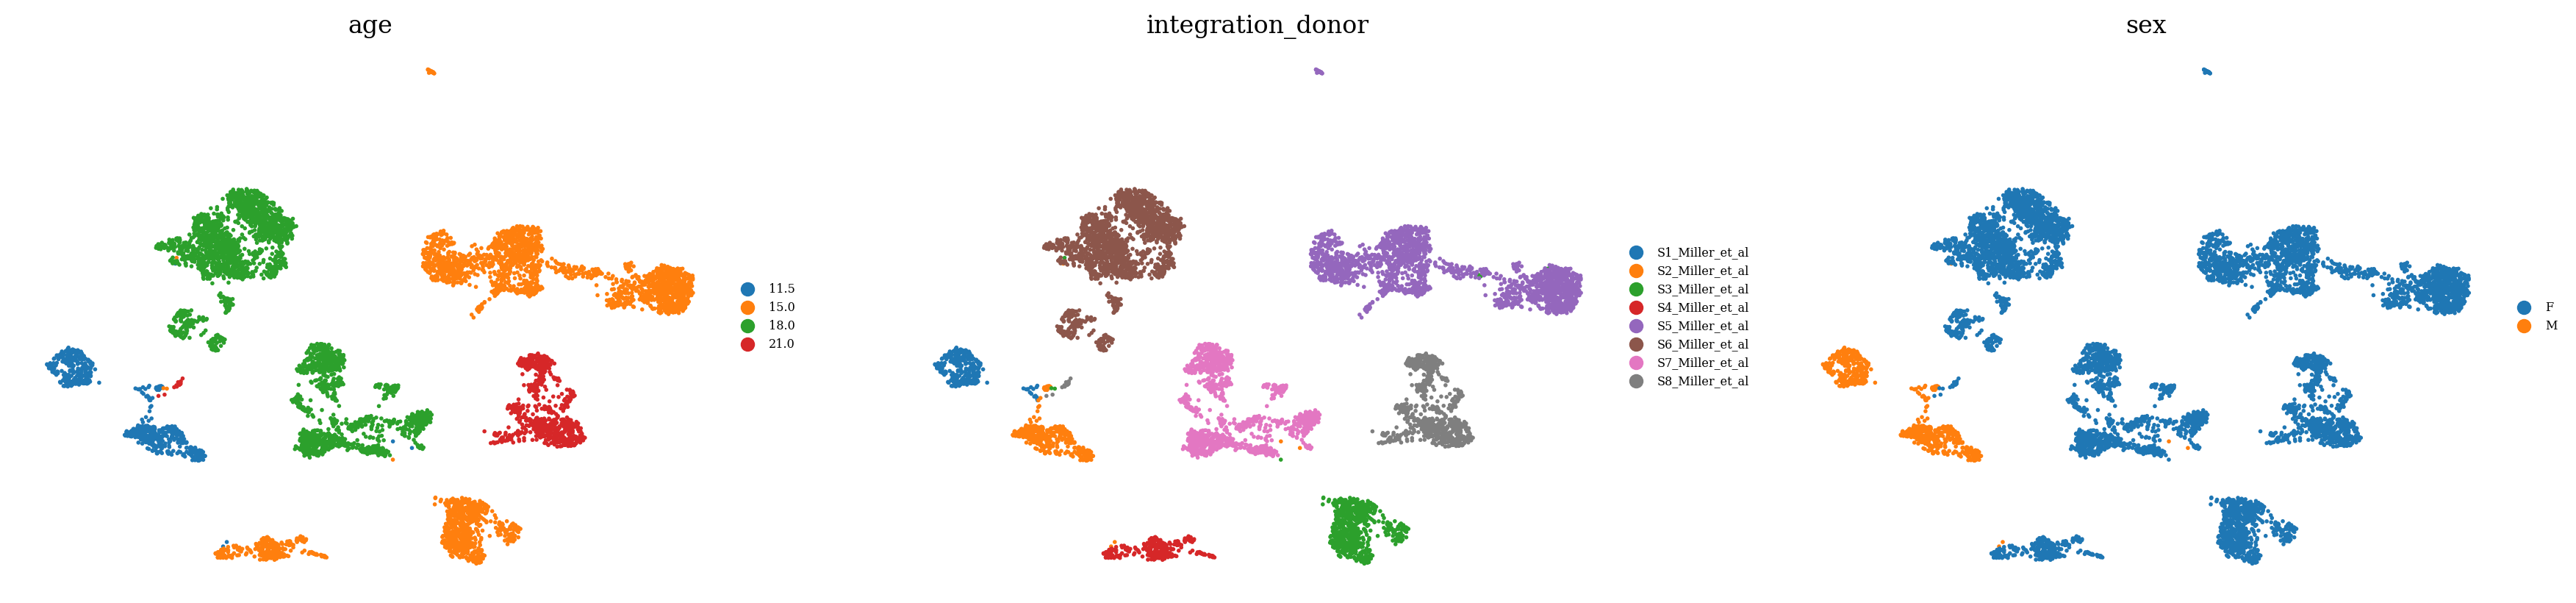

In [19]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

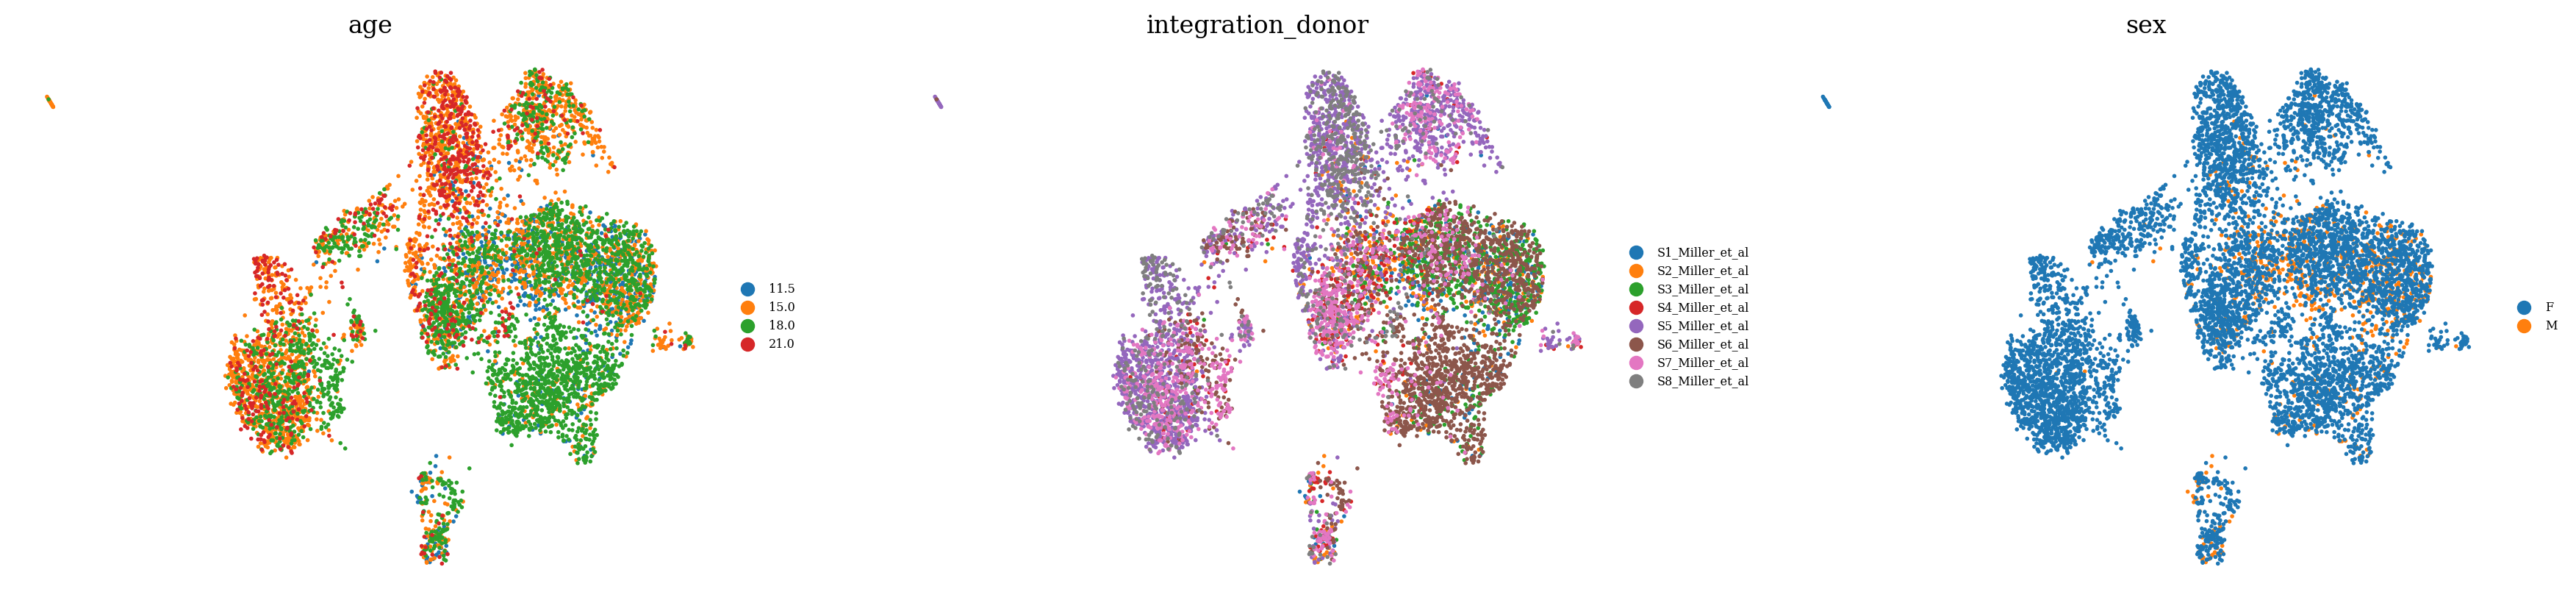

In [20]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [21]:
model.predict()

  0%|          | 0/232 [00:00<?, ?it/s]

  6%|▌         | 14/232 [00:00<00:01, 138.25it/s]

 14%|█▍        | 32/232 [00:00<00:01, 160.92it/s]

 21%|██        | 49/232 [00:00<00:01, 164.31it/s]

 29%|██▉       | 67/232 [00:00<00:00, 167.17it/s]

 36%|███▌      | 84/232 [00:00<00:01, 146.83it/s]

 43%|████▎     | 100/232 [00:00<00:00, 134.23it/s]

 49%|████▉     | 114/232 [00:00<00:00, 128.18it/s]

 55%|█████▌    | 128/232 [00:00<00:00, 124.22it/s]

 61%|██████    | 141/232 [00:01<00:00, 121.52it/s]

 66%|██████▋   | 154/232 [00:01<00:00, 119.76it/s]

 72%|███████▏  | 167/232 [00:01<00:00, 118.48it/s]

 77%|███████▋  | 179/232 [00:01<00:00, 117.57it/s]

 82%|████████▏ | 191/232 [00:01<00:00, 116.84it/s]

 88%|████████▊ | 203/232 [00:01<00:00, 116.37it/s]

 93%|█████████▎| 215/232 [00:01<00:00, 115.37it/s]

 98%|█████████▊| 227/232 [00:01<00:00, 115.18it/s]

100%|██████████| 232/232 [00:01<00:00, 126.35it/s]

In [22]:
pred_adata = adata[model.test_indices]
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [23]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.5998963518367963

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)